# PCSE 运行的示例-3

PCSE（Python Crop Simulation Environment）是一个用于作物生长模拟的Python框架，它基于WOFOST（World Food Study）模型。PCSE允许用户方便地运行和定制作物生长模型，以模拟不同环境和管理条件下的作物生长。以下是PCSE的源代码和调用方法的简要介绍。

### PCSE 源代码

PCSE的源代码托管在GitHub上，可以通过以下步骤获取：

1.  安装Git（如果尚未安装）。
2.  打开命令行工具，使用以下命令克隆PCSE仓库：

bash

复制

```
git clone https://github.com/pcse/pcse.git
```

3.  克隆完成后，可以进入`pcse`目录查看源代码。

PCSE的源代码主要分为几个部分：

-   `pcse`：包含PCSE的主要代码，如模型引擎、作物参数、土壤和水管理等。
-   `examples`：提供了一些使用PCSE的示例脚本。
-   `test`：包含用于测试PCSE的代码。



# 使用WOFOST 8.1 SNOMIN进行模拟

本Jupyter笔记本将介绍WOFOST 8.1模块及其与新的多层水分平衡和SNOMIN碳氮模型的关联。随作物生长模拟引擎（PCSE）6.0版本发布的新模型组件在模拟复杂轮作模式以及作物轮作中水分、碳和氮的遗留效应方面迈出了重要的一步。

PCSE的WOFOST作物生长模型近期已得到扩展，能够模拟受氮（N）限制的生长情况（伯格惠斯等人，2024年）。WOFOST的扩展内容包括：
- 计算作物每日的氮需求；
- 计算作物每日的氮吸收量；
- 计算氮在不同器官中的分配情况；
- 计算氮从营养器官（根、茎、叶）向储存器官的转运情况。

在非氮限制生长条件下，这些新增功能可用于计算作物的氮吸收量以及氮在不同器官中的分配情况。非氮限制条件意味着土壤中始终有足够的可利用氮来满足作物每日的氮需求。然而，倘若土壤中没有足够的氮来满足作物每日的氮需求，上述扩展功能不足以模拟氮吸收情况。因此，一个名为SNOMIN（有机和无机氮土壤氮模块）的分层土壤氮模块被开发出来，并在PCSE框架中得以应用（伯格惠斯等人，2024年）。

SNOMIN会计算不同土壤层中有机氮和无机氮（以铵态氮（${\mathrm{NH}_4}^{+}$）和硝态氮（${\mathrm{NO}_3}^{+}$）的形式）的动态变化。由于SNOMIN区分不同的土壤层，它需要与一个分层土壤水分模块相耦合，以便为每层土壤的含水量以及相邻土层间的水流提供数值。由于PCSE的经典水分平衡模型并不区分不同的土壤层，所以SNOMIN无法与该土壤水分模块相耦合。在本例中，WOFOST 8.1和SNOMIN与一个新的分层土壤水分模块（拉波尔特等人，2012年）相耦合。

WOFOST 8.1的其他相关扩展内容如下：
- 计算氮缺乏对作物生长的影响；
- 计算干物质从茎和叶向储存器官的再分配情况；
- 总（${\mathrm{CO}_2}^{+}$）同化的最大速率不再是发育阶段的表格函数（WOFOST 7.2中的`AMAXTB`）。相反，总（${\mathrm{CO}_2}^{+}$）同化的最大速率是根据特定的叶片含氮量来计算的。

WOFOST中的这些变化以及分层水分平衡和SNOMIN的加入会影响模拟的输入要求。本笔记本的目的在于：
1) 解释在WOFOST 8.1、SNOMIN和分层水分平衡相耦合的模拟中，如何获取输入信息（作物、土壤、地点、农业管理和天气方面的信息）；
2) 解释如何运行模拟；
3) 对输出结果进行可视化展示并加以解释。

为此，我们将把WOFOST 8.1/SNOMIN应用于荷兰的马铃薯作物上。

赫尔曼·伯格惠斯、阿拉德·德·维特，2024年6月

**重要提示**

本笔记本包含许多表格，用于解释运行SNOMIN所需的参数。遗憾的是，这些表格在GitHub上无法正确显示。因此，本笔记本最好在能正确显示这些表格的JupyterLab环境中使用。

**运行本笔记本的先决条件**

运行PCSE/WOFOST需要安装几个软件包：
1. PCSE 6.0及其依赖项。如需更多信息，请参阅[PCSE用户指南](http://pcse.readthedocs.io/en/stable/installing.html)；
2. 用于处理和存储WOFOST输出结果的`pandas`模块；
3. 用于生成图表的`matplotlib`模块。 

# 1. Importing the relevant modules

First the required modules need to be imported.

# 1. 导入相关模块

首先，需要导入所需的模块。

In [1]:
# 在Jupyter Notebook中设置matplotlib绘图结果内联显示，即图形直接在Notebook单元格输出区域展示，而非弹出新窗口显示
%matplotlib inline  
# 导入Python的内置系统模块，可用于获取Python版本信息、操作命令行参数等
import sys  
# 从pathlib库中导入Path类，用于更方便地操作文件和目录路径
from pathlib import Path  

# 从IPython.display模块中导入Code类，可用于在IPython环境中合适地展示代码内容（虽然此处后续未体现具体使用）
from IPython.display import Code  
# 导入yaml模块，用于读取和解析YAML格式的配置文件，方便获取程序配置参数等
import yaml  
# 导入pandas库并使用别名pd，pandas常用于数据处理、分析，提供了强大的数据结构和操作功能
import pandas as pd  
# 导入matplotlib库，它是Python中功能强大的可视化绘图库
import matplotlib  
# 设置matplotlib绘图时使用的样式为'ggplot'风格，使其绘制的图形具有类似R语言中ggplot2包的外观效果，更加美观易读
matplotlib.style.use("ggplot")  
# 从matplotlib库中导入pyplot模块并简称为plt，pyplot提供了便捷的绘图接口，方便创建各种可视化图形
import matplotlib.pyplot as plt  

# 设置中文字体为黑体，用于解决在绘制图形时中文显示的问题，
# 因为在默认情况下，有些绘图库（如matplotlib）可能无法正确显示中文，这里将字体设置为支持中文显示的黑体，
# 可根据实际情况替换为其他合适的支持中文的字体，比如宋体、楷体等，以确保图形中的中文标题、坐标轴标签等能正常显示。
plt.rcParams['font.sans-serif'] = ['SimHei']  
# 解决负号显示问题，在绘图过程中，有时坐标轴刻度等地方出现负号可能无法正常显示，
# 通过设置这个参数为False，可以让负号能够正确地在图形中展示出来，保证图形的完整性和可读性。
plt.rcParams['axes.unicode_minus'] = False  

from datetime import datetime  # 导入datetime模块，用于处理日期相关操作

# 导入pcse库，推测是与作物生长模拟相关的库，包含如WOFOST作物生长模型等功能
import pcse  
# 从pcse库的input子模块中导入YAMLCropDataProvider类，可能用于从YAML格式文件中读取作物相关数据，为作物模拟提供输入
from pcse.input import YAMLCropDataProvider  

# 打印提示信息，表明接下来要展示本笔记本是基于什么构建的
print("This notebook was built with:")  
# 打印当前Python的版本信息，通过sys模块的version属性获取
print(f"python version: {sys.version}")  
# 打印pcse库的版本信息，通过pcse库的__version__属性获取
print(f"PCSE version: {pcse.__version__}")  

This notebook was built with:
python version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
PCSE version: 6.0.8


### Setting paths for I/O
### 设置输入/输出路径

In [2]:
# 使用Path类获取当前工作目录，并与"data"、"wofost81"目录名拼接，构建出一个表示数据目录的路径对象，
# 该目录可能用于存放与WOFOST 8.1相关的数据文件等
data_dir = Path.cwd() / "data" / "wofost81"  

# 在刚才构建的data_dir基础上，进一步拼接"input"目录名，构建出表示输入文件所在目录的路径对象，
# 预计后续用于存放模拟的输入数据，比如作物、土壤等相关参数文件
input_dir = data_dir / "input"  

# 在input_dir基础上再拼接"crop"目录名，构建出专门存放作物相关输入文件的目录路径对象，
# 可能存放作物品种特性、生长参数等特定于作物的数据文件
crop_dir = input_dir / "crop"  

# 在data_dir基础上拼接"output"目录名，构建出表示输出文件存放目录的路径对象，
# 用于后续存放WOFOST 8.1模拟运行产生的各种结果文件
output_dir = data_dir / "output"  

# 将data_dir转换为字符串形式，并添加到Python的模块搜索路径中，
# 这样Python解释器就能在这个目录及其子目录下查找可能需要导入的模块或包等内容
sys.path.append(str(data_dir))  

## 2. Obtaining input data 
### 2.1 Crop parameters
Crop parameters are read from YAML files. The collection of WOFOST YAML crop parameter files are [available on github](https://github.com/ajwdewit/wofost_crop_parameters). YAML files for different model version reside on different branches within the repository. However, for this notebook we will simply read the crop parameters from local files.

## 2. 获取输入数据
### 2.1 作物参数
作物参数从YAML文件中读取。WOFOST的YAML作物参数文件集合可在[GitHub上获取](https://github.com/ajwdewit/wofost_crop_parameters)。不同模型版本的YAML文件存放在该仓库内的不同分支中。不过，在本笔记本中，我们仅从本地文件读取作物参数。 

In [3]:
# 创建一个YAMLCropDataProvider类的实例，传入参数fpath并指定其值为crop_dir，
# 目的是利用这个实例从指定的作物数据目录（crop_dir，之前构建的存放作物相关输入文件的目录路径）中读取作物参数，
# 并将读取到的参数以合适的格式整理存储（可能是字典等便于后续使用的数据结构），最终赋值给crop_dict变量。
crop_dict = YAMLCropDataProvider(fpath=crop_dir)

The soil module SNOMIN requires various input variables that are often defined per soil layer. The soil file contains all input variables that are not year-specific, This section will explain to combine these input variables in a dictionary and subsequently in a soil file that SNOMIN can read.

The modules SNOMIN and WaterbalanceLayered requires the following soil variables defined for the soil profile:

<div style="display: inline-block">
    
|Variable |Meaning| Unit|
|:-----|:-----|:---
|PFFieldCapacity|pF value of a soil layer at which its soil moisture content is at field capacity|log(cm $\mathrm{H}_{2}\mathrm{O}$)
|PFWiltingPoint|pF value of a soil layer at which its soil moisture content is at wilting point|log(cm $\mathrm{H}_{2}\mathrm{O}$)
|SurfaceConductivity|Hydraulic conductivity of the surface|$\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O}$ $\mathrm{s}^{-1}$|

</div>

We will define the values of these variables before

土壤模块SNOMIN需要各种输入变量，这些变量通常是按土壤层来定义的。土壤文件包含了所有非特定年份的输入变量。本节将讲解如何将这些输入变量整合到一个字典中，随后再整合到一个可供SNOMIN读取的土壤文件里。

模块SNOMIN和分层水分平衡（WaterbalanceLayered）需要为土壤剖面定义以下土壤变量：

|变量|含义|单位|
|:-----|:-----|:---|
|田间持水量pF值（PFFieldCapacity）|土壤层土壤含水量达到田间持水量时的pF值|对数（厘米水高，单位为cm $\mathrm{H}_{2}\mathrm{O}$）|
|凋萎点pF值（PFWiltingPoint）|土壤层土壤含水量达到凋萎点时的pF值|对数（厘米水高，单位为cm $\mathrm{H}_{2}\mathrm{O}$）|
|地表导水率（SurfaceConductivity）|地表的水力传导率|厘米水高·秒⁻¹（$\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O}$ $\mathrm{s}^{-1}$）|

我们将在之前定义这些变量的值。 

In [4]:
# 定义田间持水量对应的pF值，这里将其赋值为2.0，表示土壤层土壤含水量达到田间持水量时的pF值为该设定值，
# 单位为对数（厘米水高，即log(cm H₂O)），后续会作为土壤相关输入参数提供给相应模块使用，比如SNOMIN模块等
PFFieldCapacity = 2.0  
# 定义凋萎点对应的pF值，赋值为4.2，意味着当土壤层土壤含水量达到凋萎点时的pF值设定为此数值，
# 同样单位为对数（厘米水高，log(cm H₂O)），是土壤模块（如SNOMIN等）所需的重要土壤特征参数之一
PFWiltingPoint = 4.2  
# 定义地表的水力传导率，赋值为75.，单位为厘米水高·秒⁻¹（cm H₂O s⁻¹），
# 该参数用于描述地表的导水能力情况，会作为输入数据提供给相关土壤模块（像SNOMIN和WaterbalanceLayered模块等）来进行相应计算和模拟
SurfaceConductivity = 75.

#### Layer properties

Moreover, SNOMIN and WATFDGW require values for the following 8 properties for each soil layer:

<div style="display: inline-block">
    
|Property |Meaning| Unit|
|:-----|:-----|:---
|Thickness|Soil layer thickness|cm|
|CNRatioSOMI|C:N ratio of organic matter|kg C $\mathrm{kg}^{-1}$  N|
|CRAIRC|Critical air content|$\mathrm{m}^{3}$ air $\mathrm{m}^{3}$ soil|
|FSOMI|Initial fraction of soil organic matter|kg OM $\mathrm{kg}^{-1}$ soil|
|RHOD|Bulk density|kg soil $\mathrm{m}^{-3}$ soil|
|Soil_pH|Soil pH|log(mol $\mathrm{H}^{+}$ $\mathrm{L}^{-1}$)|
|SMfromPF|Table function that describes the volumetric soil moisture content as a function of pF air content |$\mathrm{log}(\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O})$, $\mathrm{cm}^{3}$ $\mathrm{H}_{2}\mathrm{O}$ $\mathrm{cm}^{-3}$ soil|
|CONDfromPF|Table function that describes the 10-base logarithm as a function of pF air content|$\mathrm{log}(\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O})$, $\mathrm{log}(\mathrm{cm}$ $\mathrm{H}_{2}\mathrm{O}$ $\mathrm{s}^{-1})$|

</div>

The first 6 properties are **scalar** values, the last 2 are **tabular** properties which describe functional shapes. 

We will define the first 6 with the variables below as lists, where each list element contains the value of this property for a particular soil layer. In this case we will use four soil layers:

#### 土层特性

此外，SNOMIN（土壤氮模块）和WATFDGW（可能是某种与水相关的模块，需结合具体背景确定）需要为每一层土壤设定以下8种特性的数值：

|特性|含义|单位|
|:-----|:-----|:---|
|厚度（Thickness）|土壤层的厚度|厘米|
|土壤有机质碳氮比（CNRatioSOMI）|有机质的碳氮比|千克碳·千克⁻¹氮|
|临界含气量（CRAIRC）|临界空气含量|立方米空气·立方米土壤⁻¹|
|土壤初始有机质占比（FSOMI）|土壤中初始有机质所占的比例|千克有机质·千克⁻¹土壤|
|土壤容重（RHOD）|土壤容重|千克土壤·立方米土壤⁻¹|
|土壤酸碱度（Soil_pH）|土壤酸碱度|对数（摩尔氢离子·升⁻¹）|
|基于pF值的土壤含水量（SMfromPF）|描述土壤体积含水量随pF空气含量变化的表格函数|对数（厘米水高），立方厘米水·立方厘米土壤⁻¹|
|基于pF值的导水率（CONDfromPF）|描述以10为底的对数随pF空气含量变化的表格函数|对数（厘米水高），对数（厘米水高·秒⁻¹）|

前6种特性是**标量**值，后2种是**表格**属性，用于描述函数形状。

我们将使用以下变量把前6种特性定义为列表，其中每个列表元素包含某一特定土壤层的该特性值。在这种情况下，我们将使用四层土壤： 

In [5]:
# 定义一个列表Thickness，用于表示各土壤层的厚度，列表中的每个元素依次对应每一层土壤的厚度值（单位为厘米），
# 这里设定了四层土壤，厚度值分别为25厘米、15厘米、20厘米、60厘米，后续会作为土层特性参数提供给相关模块（如SNOMIN等）使用
Thickness = [25., 15., 20., 60]  
# 通过获取Thickness列表的长度来确定土壤的层数，这样后续在涉及循环遍历各土壤层等操作时，可以方便地依据此变量知晓层数信息
nlayers = len(Thickness)  
# 定义一个列表CNRatioSOMI，用于存放各土壤层中有机质的碳氮比（单位为千克碳·千克⁻¹氮），
# 列表中的元素依次对应各层土壤的该比值，这里四层土壤的碳氮比分别设定为17、25、25、25
CNRatioSOMI = [17., 25., 25., 25.]  
# 定义一个列表CRAIRC，用于表示各土壤层的临界空气含量（单位为立方米空气·立方米土壤⁻¹），
# 各元素对应各层土壤的临界空气含量值，此处四层土壤的临界空气含量均设定为0.09
CRAIRC = [0.09, 0.09, 0.09, 0.09]  
# 定义一个列表FSOMI，用于存放各土壤层中土壤初始有机质所占的比例（单位为千克有机质·千克⁻¹土壤），
# 列表元素依次对应各层该比例的值，四层土壤的初始有机质占比分别设定为0.05、0.02、0.01、0
FSOMI = [0.05, 0.02, 0.01, 0.]  
# 定义一个列表RHOD，用于表示各土壤层的土壤容重（单位为千克土壤·立方米土壤⁻¹），
# 各元素对应各层土壤的容重值，四层土壤的容重分别设定为1.375、1.576、1.633、1.672
RHOD = [1.375, 1.576, 1.633, 1.672]  
# 定义一个列表SMW（从变量名推测可能是和土壤含水量相关的一个临时变量，可能后续还会进一步处理或者使用场景特定），
# 这里暂时将四层土壤对应的该值都设为0.1，具体单位等含义需结合更详细的程序上下文确定，可能和土壤含水量有关的某个中间量
SMW = [0.1, 0.1, 0.1, 0.1]  
# 定义一个列表Soil_pH，用于存放各土壤层的土壤酸碱度（单位为对数（摩尔氢离子·升⁻¹）），
# 列表元素依次对应各层土壤的酸碱度值，四层土壤的酸碱度分别设定为4.8、4.5、4.5、4.7
Soil_pH = [4.8, 4.5, 4.5, 4.7]  

The distribution of these variables with soil depth is shown in the figures below. It demonstrates that the C:N-ratio of organic matter is lower in the upper layers, critical air content is assumed constant, while the fraction of organic matter strongly declines with depth. The bulk density is slightly lower in the upper layers (effect of ploughing) while the soil pH is effectively constant with depth.

这些变量随土壤深度的分布情况如下图所示。图中显示，有机质的碳氮比在上层土壤中较低，临界空气含量假定为恒定值，而有机质占比随深度增加大幅下降。土壤容重在上层略低（受耕作影响），土壤酸碱度实际上不随深度变化而保持恒定。

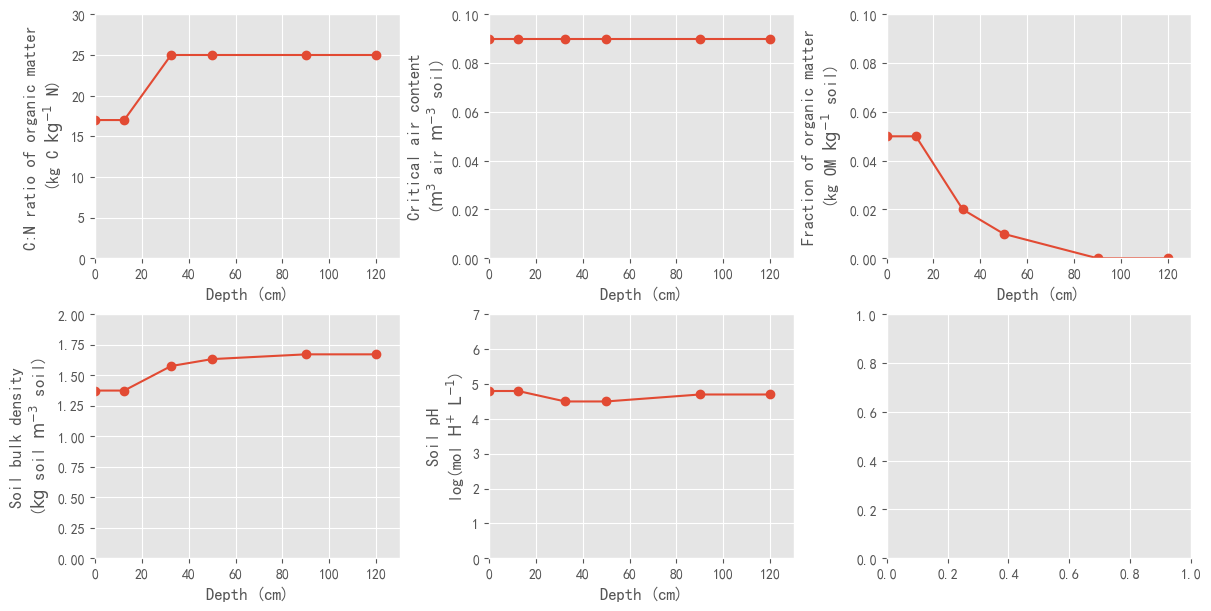

In [6]:
# 从名为w81_plotting的模块中导入名为plot_SNOMIN_parameters的函数，
# 推测这个函数的功能是用于绘制和SNOMIN模块相关参数的可视化图形，
# 比如展示这些参数随土壤深度等维度变化的情况，方便直观分析各参数的分布特征等。
from w81_plotting import plot_SNOMIN_parameters  
# 调用plot_SNOMIN_parameters函数，并传入Thickness（各土壤层厚度列表）、CNRatioSOMI（各土壤层有机质碳氮比列表）、
# CRAIRC（各土壤层临界空气含量列表）、FSOMI（各土壤层初始有机质占比列表）、RHOD（各土壤层土壤容重列表）、
# Soil_pH（各土壤层土壤酸碱度列表）这些参数，函数执行后会返回一个图形对象（可能是matplotlib的Figure对象等），
# 并将其赋值给fig变量，以便后续可以对该图形进行进一步操作，比如保存、展示等操作（虽然此处后续代码未体现相关进一步操作内容）。
fig = plot_SNOMIN_parameters(Thickness, CNRatioSOMI, CRAIRC, FSOMI, RHOD, Soil_pH)

#### Hydraulic properties
Finally, two tabular parametes have to be defined that describe the soil moisture content (SM) and the 10-base logarithm of the hydraulic conductivity (COND) as a function of the hydraulic head (pF) for each soil layer.

One way to calculate the elements of the table functions *SMfromPF* and *CONDfromPF* is to obtain the *Van Genuchten* parameters *alpha*, *lambda*, *n*, *k_sat* (saturated hydraulic conductivity; cm d-1) and *theta_r* (residual soil moisture content) and *theta_s* (soil moisture content at saturation) and use them to calculate the values of SM and COND for various values of pF. These Van Genuchten parameters have to be specified for each soil layer:

#### 水力特性
最后，必须定义两个表格参数，用于描述每一层土壤的土壤含水量（SM）以及水力传导率（COND）以10为底的对数随水头（pF）变化的函数关系。

计算表格函数 *SMfromPF* 和 *CONDfromPF* 各元素的一种方法是获取 *范格努钦*（*Van Genuchten*）参数，即 *α*（阿尔法）、*λ*（兰姆达）、*n*、*k_sat*（饱和水力传导率，单位为厘米/天）以及 *θ_r*（残余土壤含水量）和 *θ_s*（饱和土壤含水量），并利用它们来计算不同pF值对应的土壤含水量（SM）和水力传导率（COND）的值。这些范格努钦参数必须针对每一层土壤分别进行设定。 

In [7]:
# 定义一个列表alpha（对应范格努钦参数中的阿尔法），列表中的每个元素依次代表每一层土壤对应的阿尔法值，
# 这些值将用于后续结合其他范格努钦参数来计算土壤含水量（SM）和水力传导率（COND）随pF值变化的相关数值，
# 此处为四层土壤分别设定了相应的alpha值，单位等具体物理含义需结合范格努钦模型相关知识来确定。
alpha = [0.02164487, 0.01608317, 0.01608317, 0.01598691]  
# 定义一个列表k_sat（对应范格努钦参数中的饱和水力传导率），单位为厘米/天（cm d-1），
# 列表元素依次是各层土壤的饱和水力传导率值，用于描述每层土壤在饱和状态下导水能力的强弱，
# 四层土壤分别设定了对应的k_sat值，后续参与到相关水力特性相关计算中。
k_sat = [83.24163508, 22.76175599, 22.76175599, 22.32215442]  
# 定义一个列表labda（对应范格努钦参数中的兰姆达），每个元素对应各层土壤的兰姆达值，
# 同样该参数会与其他范格努钦参数共同作用，辅助计算土壤水力特性相关的一些函数数值，四层土壤各自有对应的labda值设定在此列表中。
labda = [7.20207718, 2.43966226, 2.43966226, 2.8679672]  
# 定义一个列表n，对应范格努钦参数中的n值，列表内各元素按顺序表示各层土壤的n值，
# 在依据范格努钦模型计算土壤含水量、水力传导率随pF变化等情况时，该参数起着重要作用，四层土壤分别有对应的n值设定在此。
n = [1.34877009, 1.52441823, 1.52441823, 2.16275113]  
# 定义一个列表theta_r（对应范格努钦参数中的残余土壤含水量），每个元素表示每层土壤的残余土壤含水量，
# 即土壤在经过排水等过程后剩余的最小含水量，四层土壤分别设定了对应的theta_r值，其会参与到相关水力特性计算当中。
theta_r = [0.02, 0.02, 0.02, 0.01]  
# 定义一个列表theta_s（对应范格努钦参数中的饱和土壤含水量），各元素依次代表各层土壤达到饱和状态时的含水量，
# 用于衡量每层土壤在饱和情况下所能容纳水分的量，四层土壤各自设定了对应的theta_s值，在后续水力特性相关计算中会用到该参数。
theta_s = [0.43387803, 0.3870639, 0.3870639, 0.36584689]  

We will calculate SMfromPF and CONDfromPF for the following pF values

我们将针对以下pF值来计算基于pF值的土壤含水量（SMfromPF）和基于pF值的水力传导率（CONDfromPF）。

In [8]:
# 定义一个列表pFs，用于存储一系列的pF值。这些pF值将作为自变量，
# 后续会基于它们以及前面定义的范格努钦（Van Genuchten）参数等来计算相应的土壤含水量（SMfromPF）和水力传导率（CONDfromPF），
# 从而构建起描述土壤水力特性随pF值变化的函数关系，每个元素代表一个具体的pF取值。
pFs = [-1.0, 1.0, 1.3, 1.7, 2.0, 2.3, 2.4, 2.7, 3.0, 3.3, 3.7, 4.0, 4.2, 6.0]

The table function SMfromPF and CONDfromPF can now be constructed:

现在可以构建表格函数“基于pF值的土壤含水量（SMfromPF）”以及“基于pF值的水力传导率（CONDfromPF）”了。

In [9]:
# 从名为vangenuchten的模块中导入三个函数，分别是calculate_water_potential_form_pf（可能用于根据pF值计算水势相关内容，此处未直接使用）、
# calculate_soil_moisture_content（用于根据给定的pF值以及对应土层的相关范格努钦参数来计算土壤含水量）、
# calculate_log10_hydraulic_conductivity（用于依据给定的pF值和对应土层的相关范格努钦参数来计算以10为底的对数形式的水力传导率）
from vangenuchten import calculate_water_potential_form_pf, calculate_soil_moisture_content, calculate_log10_hydraulic_conductivity  

# 创建一个空列表CONDfromPF_perlayer，用于存储每一层土壤的基于pF值的水力传导率（CONDfromPF）数据，
# 后续会将每层土壤计算得到的对应数据添加到这个列表中，最终形成一个包含各层土壤相关数据的列表结构。
CONDfromPF_perlayer = []  
# 创建一个空列表SMfromPF_perlayer，目的是用来存放每一层土壤的基于pF值的土壤含水量（SMfromPF）数据，
# 之后会把每层土壤经过计算得出的相应数据依次添加进来，以构建起包含各层土壤该数据的列表。
SMfromPF_perlayer = []  

# 开始循环遍历每一层土壤，这里的nlayers是之前通过土层厚度列表Thickness的长度获取到的，表示土壤的总层数，
# 通过这个循环，可以针对每一层土壤分别进行后续的计算操作，以构建每层对应的SMfromPF和CONDfromPF数据。
for i in range(nlayers):  
    # 在每一层土壤的循环内部，创建一个空列表CONDfromPF，用于临时存储当前层土壤在不同pF值下计算得到的基于pF值的水力传导率数据，
    # 后续在内部的小循环中会不断添加数据进来，然后整体添加到CONDfromPF_perlayer列表中。
    CONDfromPF = []  
    # 同样在每一层土壤的循环内，创建一个空列表SMfromPF，用于临时存放当前层土壤在不同pF值下计算得出的基于pF值的土壤含水量数据，
    # 之后会在小循环里逐步添加相应数据，最后添加到SMfromPF_perlayer列表中。
    SMfromPF = []  
    # 开始内层循环，使用enumerate函数同时获取索引j和对应元素pF，这里的pFs是之前定义的包含多个pF值的列表，
    # 通过这个循环可以依次取出每个pF值，用于针对当前层土壤（由外层循环的i决定）计算相应的土壤含水量和水力传导率。
    for j, pF in enumerate(pFs):  
        # 调用calculate_soil_moisture_content函数，传入当前的pF值以及当前层土壤（由i指定）对应的范格努钦参数alpha、n、theta_r、theta_s，
        # 计算出当前pF值下的土壤含水量，并将结果赋值给变量r，该函数的作用就是依据相关参数和pF值来确定土壤含水量的具体数值。
        r = calculate_soil_moisture_content(pF, alpha[i], n[i], theta_r[i], theta_s[i])  
        # 将当前的pF值和计算得到的土壤含水量r添加到SMfromPF列表中，注意这里使用extend方法是将两个元素作为独立元素依次添加进去，
        # 如此循环结束后，SMfromPF列表就会包含一系列成对的pF值和对应的土壤含水量数据，用于描述当前层土壤的相关特性。
        SMfromPF.extend([pF, r])  
        # 调用calculate_log10_hydraulic_conductivity函数，传入当前的pF值以及当前层土壤（由i指定）对应的范格努钦参数alpha、labda、k_sat、n，
        # 计算出当前pF值下以10为底的对数形式的水力传导率，并把结果赋值给变量r，此函数旨在根据相关参数和pF值来算出对应的水力传导率数值。
        r = calculate_log10_hydraulic_conductivity(pF, alpha[i], labda[i], k_sat[i], n[i])  
        # 将当前的pF值和计算得到的水力传导率r添加到CONDfromPF列表中，同样是使用extend方法依次添加两个元素，
        # 这样循环结束后，CONDfromPF列表就存有一系列成对的pF值和对应的水力传导率数据，以体现当前层土壤在这方面的特性。
        CONDfromPF.extend([pF, r])  
    # 将当前层土壤计算好的基于pF值的水力传导率数据列表CONDfromPF添加到CONDfromPF_perlayer列表中，
    # 使得CONDfromPF_perlayer列表最终包含了所有层土壤的相应数据，形成一个多层结构的数据集，每层的数据又由多个pF值对应的水力传导率数据组成。
    CONDfromPF_perlayer.append(CONDfromPF)  
    # 把当前层土壤算好的基于pF值的土壤含水量数据列表SMfromPF添加到SMfromPF_perlayer列表中，
    # 进而让SMfromPF_perlayer列表汇聚了各层土壤的相关数据，构建出一个多层结构的数据集合，每层的数据由多个pF值对应的土壤含水量数据构成。
    SMfromPF_perlayer.append(SMfromPF)  

The response functions of the soil moisture content to the pF in the different layers look like the figures below. It demonstrates that with increasing suction (pF) the amount of moisture in the soil decreases:

不同土层中土壤含水量对pF值的响应函数如下图所示。图中显示，随着吸力（pF值）的增大，土壤中的含水量会减少。

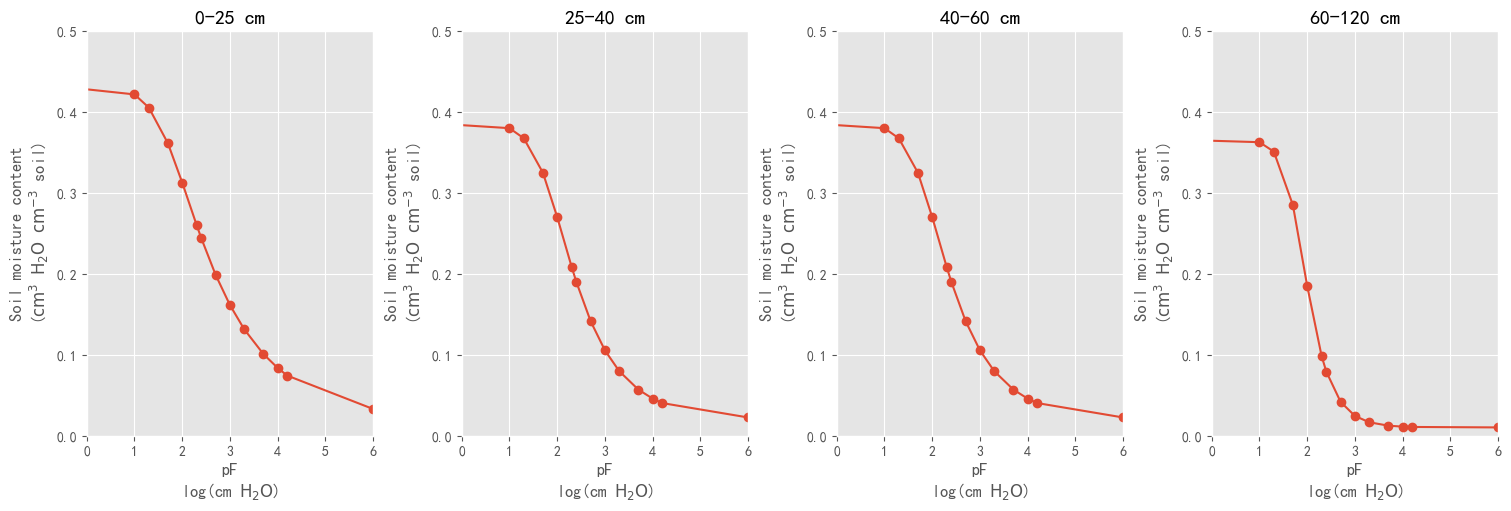

In [10]:
# 从名为w81_plotting的模块中导入名为plot_pF_vs_soilmoisture的函数。
# 从函数名推测，其功能大概率是用于绘制土壤含水量与pF值之间关系的可视化图形，
# 可能会依据传入的不同土层的土壤含水量数据、土层厚度以及pF值等参数来生成相应的图表，便于直观展示土壤特性相关情况。
from w81_plotting import plot_pF_vs_soilmoisture  

# 调用plot_pF_vs_soilmoisture函数，并传入SMfromPF_perlayer（之前计算得到的各层土壤基于pF值的土壤含水量数据列表）、
# Thickness（各土层厚度列表，用于体现不同土层的相关信息，可能在绘图中用于区分不同土层等作用）、
# pFs（之前定义的一系列pF值列表，作为自变量用于绘制与土壤含水量的对应关系）这三个参数。
# 函数执行后会返回一个图形对象（可能是matplotlib的Figure对象等），并将其赋值给fig变量，
# 以便后续可以对该图形进行进一步操作，比如保存、展示等操作（虽然此处后续代码未体现相关进一步操作内容）。
fig = plot_pF_vs_soilmoisture(SMfromPF_perlayer, Thickness, pFs)

And the response function of the 10-base logarithm to hydraulic conductivity to the pF looks like below. It clearly demonstrates that hydraulic conductivity is decreasing with increase pF values.:

而水力传导率以10为底的对数对pF值的响应函数如下图所示。它清楚地表明，水力传导率随着pF值的增大而减小。

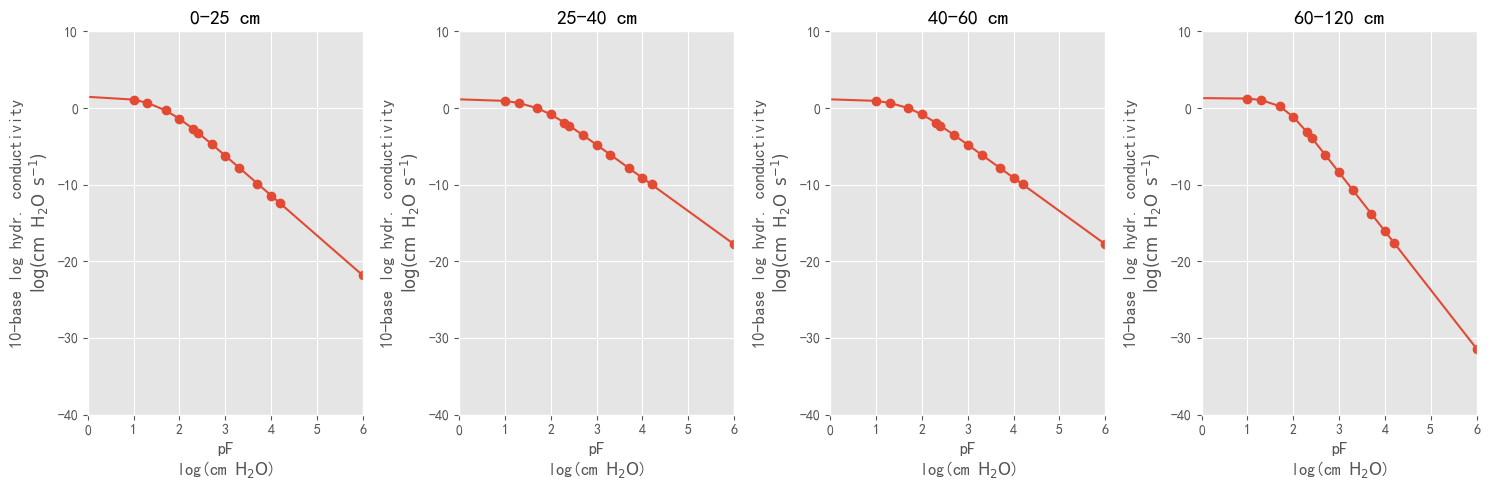

In [11]:
# 从名为w81_plotting的模块中导入名为plot_pF_vs_conductivity的函数。
# 从函数名可推测出，其功能应该是用于绘制水力传导率（以10为底的对数形式）与pF值之间关系的可视化图形，
# 会依据传入的各层土壤对应的基于pF值的水力传导率数据、土层厚度以及pF值等参数来生成相应图表，方便直观查看相关变化趋势及各土层情况。
from w81_plotting import plot_pF_vs_conductivity  

# 调用plot_pF_vs_conductivity函数，并传入CONDfromPF_perlayer（之前经过计算所得到的各层土壤基于pF值的水力传导率数据列表，
# 这里的数据是以10为底的对数形式，反映了不同pF值下各层土壤的水力传导特性）、
# Thickness（各土层厚度列表，可用于在绘图中区分不同土层，比如不同土层在图中以不同颜色或线条样式展示，且厚度信息也有助于体现各土层特征差异）、
# pFs（之前定义好的一系列pF值列表，作为自变量，用于构建与水力传导率的对应关系）这三个参数。
# 函数执行后会返回一个图形对象（可能是matplotlib的Figure对象等），并将其赋值给fig变量，
# 这样后续可以对该图形进行进一步操作，例如将图形保存下来、在合适的界面展示等（不过此处后续代码并没有体现这些进一步的操作内容）。
fig = plot_pF_vs_conductivity(CONDfromPF_perlayer, Thickness, pFs)

All information that is required to build a soil inputs is now available. We can now assemble everything into the right structure. We will use YAML to demonstrate the data structure:

构建土壤输入所需的所有信息现在均已齐备。我们现在可以将所有内容整合到正确的结构中。我们将使用YAML（一种标记语言）来展示数据结构：

In [12]:
# 从名为vangenuchten的模块中导入make_string_table函数，
# 从函数名推测其功能可能是将相关数据（比如与土壤特性相关的数据列表等）转换为适合以字符串形式表示的表格结构，
# 以便后续在构建YAML格式的土壤输入文件内容时使用，符合YAML语法要求来展示数据。
from vangenuchten import make_string_table  

# 下面我们生成土壤输入文件头部的内容，将其构建为YAML输入结构格式。
# 这里的注释"SMW:{sum(Thickness)}"可能是一种提示信息，表明后续可能会按照土层厚度总和来处理SMW相关内容（不过此处未直接体现完整逻辑）。
# 首先初始化一个多行字符串soil_input_yaml，使用f-string格式化字符串的方式来构建符合YAML语法的内容，
# 设置了RDMSOL字段的值为所有土层厚度的总和（sum(Thickness)），该字段含义可能与土壤整体的某个深度相关属性有关，需结合具体应用场景确定。
soil_input_yaml = f"""
RDMSOL: {sum(Thickness)}

SoilProfileDescription:
    PFWiltingPoint: {PFWiltingPoint}
    PFFieldCapacity: {PFFieldCapacity}
    SurfaceConductivity: {SurfaceConductivity}
    GroundWater: false
    SoilLayers:
"""

# 这里开始循环遍历每一层土壤，nlayers表示土壤的总层数，通过这个循环来为每一层土壤生成对应的属性信息，
# 并按照YAML的语法格式将其添加到soil_input_yaml字符串中，包括土层厚度、水力特性、有机质含量等多方面的属性内容。
for i in range(nlayers):  
    # 在每一层土壤的循环内部，使用f-string格式化字符串构建一段符合YAML语法的字符串s，
    # 用于表示当前层土壤的各项属性信息，每项属性都从之前定义好的对应列表中取出相应元素（通过索引i）来赋值，
    # 比如土层厚度（Thickness）、有机质碳氮比（CNRatioSOMI）等，同时对于像SMfromPF和CONDfromPF这样需要特殊格式处理的属性，
    # 调用make_string_table函数将对应的数据列表（如SMfromPF_perlayer[i]和CONDfromPF_perlayer[i]）转换为合适的字符串表格形式进行赋值，
    # 最终形成一段完整描述当前层土壤属性的YAML格式字符串。
    s = f"""    - Thickness: {Thickness[i]}
      CNRatioSOMI: {CNRatioSOMI[i]}
      CRAIRC: {CRAIRC[i]}
      FSOMI: {FSOMI[i]}
      RHOD: {RHOD[i]}
      
      Soil_pH: {Soil_pH[i]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[i])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i])}
      SMW: {SMW[i]}
"""
    # 将当前层土壤构建好的YAML格式字符串s添加到总的soil_input_yaml字符串中，逐步构建起完整的包含各层土壤属性信息的YAML内容。
    soil_input_yaml += s

# 需要定义一个SubSoilType（可能表示下层土壤类型相关属性，具体含义需结合整体应用场景确定）。
# 在这种情况下，我们将下层土壤的属性设置为与最深层土壤的属性相等，
# 通过从各属性列表中取出最后一个元素（索引为-1，表示最后一个元素）来构建符合YAML语法的字符串内容，
# 同样对SMfromPF和CONDfromPF属性调用make_string_table函数进行合适的格式转换后赋值，
# 并将其添加到soil_input_yaml字符串中，完善整个土壤输入数据结构的定义。
soil_input_yaml += \
f"""    SubSoilType:
      CNRatioSOMI: {CNRatioSOMI[-1]}
      CRAIRC: {CRAIRC[-1]}
      FSOMI: {FSOMI[-1]}
      RHOD: {RHOD[-1]}
      
      Soil_pH: {Soil_pH[-1]}
      Thickness: {Thickness[-1]}
      SMfromPF: {make_string_table(SMfromPF_perlayer[-1])}
      CONDfromPF: {make_string_table(CONDfromPF_perlayer[i-1])}
      SMW: {SMW[-1]}
"""

# 使用yaml模块的safe_load函数将构建好的YAML格式字符串soil_input_yaml解析为一个有效的Python字典结构（可能用于后续更方便地在程序中处理土壤相关数据），
# 并将解析后的结果赋值给soil_dict变量，这样就可以按照字典的操作方式来访问和使用其中的土壤数据信息了。
soil_dict = yaml.safe_load(soil_input_yaml)  

# 打印土壤输入数据结构，这里调用Code函数（可能是自定义的用于以某种特定格式展示代码或数据结构的函数，具体功能取决于其定义），
# 将soil_input_yaml作为参数传入，同时指定language="python"，可能是为了以符合Python语言相关的展示风格来输出土壤输入数据结构内容，方便查看和调试。
Code(soil_input_yaml, language="python")  

RDMSOL: 120.0

SoilProfileDescription:
    PFWiltingPoint: 4.2
    PFFieldCapacity: 2.0
    SurfaceConductivity: 75.0
    GroundWater: false
    SoilLayers:
    - Thickness: 25.0
      CNRatioSOMI: 17.0
      CRAIRC: 0.09
      FSOMI: 0.05
      RHOD: 1.375
      
      Soil_pH: 4.8
      SMfromPF: [-1.0, 0.4339, 1.0, 0.4213, 1.3, 0.4050, 1.7, 0.3610, 2.0, 0.3124, 2.3, 0.2602, 2.4, 0.2436, 2.7, 0.1984, 3.0, 0.1611, 3.3, 0.1311, 3.7, 0.1007, 4.0, 0.0834, 4.2, 0.0740, 6.0, 0.0327, ]
      CONDfromPF: [-1.0, 1.8114, 1.0, 1.0935, 1.3, 0.6654, 1.7, -0.3195, 2.0, -1.4142, 2.3, -2.7413, 2.4, -3.2171, 2.7, -4.7014, 3.0, -6.2321, 3.3, -7.7821, 3.7, -9.8599, 4.0, -11.4212, 4.2, -12.4627, 6.0, -21.8391, ]
      SMW: 0.1
    - Thickness: 15.0
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.02
      RHOD: 1.576
      
      Soil_pH: 4.5
      SMfromPF: [-1.0, 0.3871, 1.0, 0.3796, 1.3, 0.3671, 1.7, 0.3246, 2.0, 0.2697, 2.3, 0.2087, 2.4, 0.1898, 2.7, 0.1412, 3.0, 0.1051, 3.3, 0.0794, 3.7, 0.0567, 4.0, 0.0456, 4.2, 0.0401, 6.0, 0.0223, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1
    - Thickness: 20.0
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.01
      RHOD: 1.633
      
      Soil_pH: 4.5
      SMfromPF: [-1.0, 0.3871, 1.0, 0.3796, 1.3, 0.3671, 1.7, 0.3246, 2.0, 0.2697, 2.3, 0.2087, 2.4, 0.1898, 2.7, 0.1412, 3.0, 0.1051, 3.3, 0.0794, 3.7, 0.0567, 4.0, 0.0456, 4.2, 0.0401, 6.0, 0.0223, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1
    - Thickness: 60
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.0
      RHOD: 1.672
      
      Soil_pH: 4.7
      SMfromPF: [-1.0, 0.3658, 1.0, 0.3623, 1.3, 0.3507, 1.7, 0.2846, 2.0, 0.1846, 2.3, 0.0986, 2.4, 0.0789, 2.7, 0.0415, 3.0, 0.0242, 3.3, 0.0163, 3.7, 0.0122, 4.0, 0.0110, 4.2, 0.0106, 6.0, 0.0100, ]
      CONDfromPF: [-1.0, 1.3482, 1.0, 1.2277, 1.3, 1.0404, 1.7, 0.2378, 2.0, -1.1673, 2.3, -3.1540, 2.4, -3.8799, 2.7, -6.1281, 3.0, -8.4148, 3.3, -10.7102, 3.7, -13.7737, 4.0, -16.0717, 4.2, -17.6037, 6.0, -31.3921, ]
      SMW: 0.1
    SubSoilType:
      CNRatioSOMI: 25.0
      CRAIRC: 0.09
      FSOMI: 0.0
      RHOD: 1.672
      
      Soil_pH: 4.7
      Thickness: 60
      SMfromPF: [-1.0, 0.3658, 1.0, 0.3623, 1.3, 0.3507, 1.7, 0.2846, 2.0, 0.1846, 2.3, 0.0986, 2.4, 0.0789, 2.7, 0.0415, 3.0, 0.0242, 3.3, 0.0163, 3.7, 0.0122, 4.0, 0.0110, 4.2, 0.0106, 6.0, 0.0100, ]
      CONDfromPF: [-1.0, 1.3269, 1.0, 0.9261, 1.3, 0.6586, 1.7, -0.0142, 2.0, -0.8425, 2.3, -1.9102, 2.4, -2.3012, 2.7, -3.5313, 3.0, -4.8048, 3.3, -6.0944, 3.7, -7.8221, 4.0, -9.1198, 4.2, -9.9852, 6.0, -17.7758, ]
      SMW: 0.1

## 2.3 Specifying site parameters

The model WOFOST8.1/SNOMIN also requires site parameters that are specific for a given location. The site parameters in the table below are required by WOFOST81/SNOMIN and they are most easily specified through `pcse.input.WOFOST81SiteDataProvider_SNOMIN` which checks the ranges of all site parameters and provides sensible defaults. Note that the initial amount of NH4 and NO3 (*NH4I*, *NO3I*) must be provided for each soil layer as a list. 

<div style="display: inline-block">

|Variable |Meaning| Unit|
|:-----|:-----|:---
|A0SOM|The initial age of organic matter in the soil at the start of the simulation|year|
|CNRatioBio|C:N ratio of the microbial biomass|kg C $\mathrm{kg}^{-1}$ N|
|CO2|$\mathrm{CO}_2$ concentration in the ambient air|ppm|
|FASDIS|Ratio of assimilation to dissimilation rate|-|
|IFUNRN|Flag that indicates whether the infiltration fraction of non-infiltrating rainfall is fixed (0) or depends on the rainfall amount (1)|-|
|KDENIT_REF|Reference first-order dentrification rate|$\mathrm{d}^{-1}$|
|KNIT_REF|Reference first-order nitrification rate|$\mathrm{d}^{-1}$|
|KSORP|Sorption coefficient|$\mathrm{m}^{3}$ water $\mathrm{kg}^{-1}$ soil|
|MRCDIS|Michaelis-Menten constant of relationship organic C-dissimilation rate and response factor denitrification rate|$\mathrm{kg}$ C $\mathrm{m}^{-2}$ $\mathrm{d}^{-1}$|
|NH4ConcR|${\mathrm{NH}_4}^{+}$-N concentration in rain water|mg ${\mathrm{NH}_4}^{+}$-$\mathrm{N}$ $\mathrm{L}^{-1}$ water|
|NH4I|Initial amount of ${\mathrm{NH}_4}^{+}$-N per soil layer|kg ${\mathrm{NH}_4}^{+}$-$\mathrm{N}$ $\mathrm{ha}^{-1}$|
|NO3ConcR|${\mathrm{NO}_3}^{-}$-N concentration in rain water|mg ${\mathrm{NO}_3}^{-}$-$\mathrm{N}$ $\mathrm{L}^{-1}$ water|
|NO3I|Initial amount of ${\mathrm{NO}_3}^{-}$-N per soil layer|kg ${\mathrm{NO}_3}^{-}$-$\mathrm{N}$ $\mathrm{ha}^{-1}$|
|NOTINF|Maximum fraction of rainwater that cannot infiltrate the soil|$\mathrm{m}^{-3}$ water $\mathrm{m}^{-3}$ water|
|WFPS_CRIT|Critical fraction of pores that is filled with water|$\mathrm{m}^{-3}$ water $\mathrm{m}^{-3}$ soil|
|SMLIM|Maximum initial soil moisture content in top soil|$\mathrm{m}^{-3}$ water $\mathrm{m}^{-3}$ soil|
|SSI|Initial amount of water in surface storage|cm water|
|SSMAX|Maximum amount of water in surface storage|cm water|
|WAV|Initial amount of available water|cm water|

</div>


## 2.3 指定场地参数

WOFOST8.1/SNOMIN模型还需要特定于给定位置的场地参数。下表中的场地参数是WOFOST81/SNOMIN模型所必需的，通过 `pcse.input.WOFOST81SiteDataProvider_SNOMIN` 来指定这些参数最为简便，该函数会检查所有场地参数的取值范围，并提供合理的默认值。请注意，铵态氮（*NH4I*）和硝态氮（*NO3I*）的初始含量必须以列表形式针对每一层土壤分别提供。

|变量|含义|单位|
|:-----|:-----|:---|
|A0SOM|模拟开始时土壤中有机质的初始年龄|年|
|CNRatioBio|微生物生物量的碳氮比|千克碳·千克⁻¹氮|
|CO2|周围空气中二氧化碳的浓度|ppm（百万分之一）|
|FASDIS|同化与异化速率之比|无单位|
|IFUNRN|一个标识，用于指示未入渗降雨的入渗比例是固定的（取值为0）还是取决于降雨量（取值为1）|无单位|
|KDENIT_REF|参考一级反硝化速率|天⁻¹|
|KNIT_REF|参考一级硝化速率|天⁻¹|
|KSORP|吸附系数|立方米水·千克⁻¹土壤|
|MRCDIS|描述有机碳异化速率与反硝化速率响应因子关系的米氏常数|千克碳·平方米⁻¹·天⁻¹|
|NH4ConcR|雨水中铵态氮（${\mathrm{NH}_4}^{+}$-N）的浓度|毫克铵态氮（${\mathrm{NH}_4}^{+}$-N）·升⁻¹水|
|NH4I|每一层土壤中铵态氮（${\mathrm{NH}_4}^{+}$-N）的初始含量|千克铵态氮（${\mathrm{NH}_4}^{+}$-N）·公顷⁻¹|
|NO3ConcR|雨水中硝态氮（${\mathrm{NO}_3}^{-}$-N）的含量|毫克硝态氮（${\mathrm{NO}_3}^{-}$-N）·升⁻¹水|
|NO3I|每一层土壤中硝态氮（${\mathrm{NO}_3}^{-}$-N）的初始含量|千克硝态氮（${\mathrm{NO}_3}^{-}$-N）·公顷⁻¹|
|NOTINF|无法入渗到土壤中的雨水的最大比例|立方米水·立方米水⁻¹|
|WFPS_CRIT|孔隙被水填满的临界比例|立方米水·立方米土壤⁻¹|
|SMLIM|表层土壤最大初始土壤含水量|立方米水·立方米土壤⁻¹|
|SSI|地表储水量的初始值|厘米水|
|SSMAX|地表储水量的最大值|厘米水|
|WAV|可用水量的初始值|厘米水| 

In [13]:
# 从pcse.input模块中导入WOFOST81SiteDataProvider_SNOMIN类，
# 这个类的作用是用于提供WOFOST8.1模型（结合SNOMIN相关功能时）所需的场地参数，
# 它能够检查传入参数的取值范围，并为那些未明确赋值的参数提供合理的默认值，方便构建符合模型要求的场地参数集合。
from pcse.input import WOFOST81SiteDataProvider_SNOMIN  

# 创建WOFOST81SiteDataProvider_SNOMIN类的一个实例，并将其赋值给site_dict变量。
# 在实例化过程中，通过关键字参数的方式传入了多个场地参数的值，这些参数对应着WOFOST8.1/SNOMIN模型运行所需的各种场地相关特性信息。
# 以下是对每个传入参数的详细注释：

# A0SOM参数，设置土壤中有机质的初始年龄为24.0年，用于模拟开始时对土壤有机质初始状态的描述，单位为“年”。
# 该值会影响到后续与土壤有机质演变相关的计算过程，作为模型中体现土壤历史状态的一个重要输入。
# A0SOM=24.0,  
# # CNRatioBio参数，指定微生物生物量的碳氮比为9.0，单位是千克碳·千克⁻¹氮，
# # 此参数反映了微生物生物量中碳和氮元素的相对比例关系，对于涉及微生物参与的土壤氮循环等相关过程的模拟计算有着重要作用。
# CNRatioBio=9.0,  
# # CO2参数，设定周围空气中二氧化碳的浓度为400. ppm（百万分之一），
# # 该浓度值是环境条件的一个重要表征，会影响植物的光合作用等生理过程以及整个生态系统的物质和能量交换过程，在模型中是影响作物生长等模拟的关键环境因子之一。
# CO2=400.,  
# # FASDIS参数，赋值为0.5，表示同化与异化速率之比为0.5，这是一个无单位的比例参数，
# # 用于描述生态系统中物质同化和异化这两个相反过程之间的相对速率关系，对土壤中物质循环及能量流动相关的模拟计算有着重要影响。
# FASDIS=0.5,  
# # IFUNRN参数，设置为0，表示未入渗降雨的入渗比例是固定的情况（与取值为1时表示取决于降雨量的情况相区别），
# # 该参数用于确定降雨在入渗到土壤和形成地表径流等不同去向之间的分配规则，在水文过程模拟方面起着关键作用。
# IFUNRN=0,  
# # KDENIT_REF参数，指定参考一级反硝化速率为0.06 天⁻¹，单位“天⁻¹”表示单位时间内的反应速率，
# # 反硝化作用是土壤氮循环中的重要环节，此参数定义了反硝化过程在参考条件下的反应快慢程度，影响着土壤中氮素的转化和损失情况。
# KDENIT_REF=0.06,  
# # KNIT_REF参数，设定参考一级硝化速率为1.0 天⁻¹，同样以“天⁻¹”为单位，
# # 硝化作用也是土壤氮循环的关键过程，该参数决定了硝化过程在参考状态下的反应速率，对土壤中铵态氮向硝态氮转化等相关计算有重要意义。
# KNIT_REF=1.0,  
# # KSORP参数，设置吸附系数为0.0005，单位为立方米水·千克⁻¹土壤，
# # 该系数用于描述土壤对某些物质（比如养分等）的吸附能力大小，在涉及土壤与水之间物质交换和养分动态模拟中是重要的参数。
# KSORP=0.0005,  
# # MRCDIS参数，赋值为0.001，单位是千克碳·平方米⁻¹·天⁻¹，它描述了有机碳异化速率与反硝化速率响应因子关系的米氏常数，
# # 在模拟土壤中有机碳分解以及与反硝化作用相互关联的过程中，依据此常数来确定相应的反应速率关系，对相关过程的准确模拟很关键。
# MRCDIS=0.001,  
# # NH4ConcR参数，设定雨水中铵态氮（${\mathrm{NH}_4}^{+}$-N）的浓度为1.0毫克铵态氮（${\mathrm{NH}_4}^{+}$-N）·升⁻¹水，
# # 该浓度值体现了降雨输入到土壤系统中的铵态氮含量情况，是土壤氮素输入源的一部分，会影响土壤中氮素的初始含量及后续动态变化。
# NH4ConcR=1.0,  
# # NH4I参数，以列表形式[5., 0., 0., 0.]传入，代表每一层土壤中铵态氮（${\mathrm{NH}_4}^{+}$-N）的初始含量，单位为千克铵态氮（${\mathrm{NH}_4}^{+}$-N）·公顷⁻¹，
# # 这里设定了四层土壤的初始铵态氮含量，只有第一层土壤初始含量为5千克/公顷，其余三层为0，用于准确描述土壤氮素在不同土层初始分布情况，供模型后续计算使用。
# NH4I=[5., 0., 0., 0.],  
# # NO3ConcR参数，指定雨水中硝态氮（${\mathrm{NO}_3}^{-}$-N）的浓度为4.0毫克硝态氮（${\mathrm{NO}_3}^{-}$-N）·升⁻¹水，
# # 类似NH4ConcR参数，此参数表示降雨带来的硝态氮输入情况，是土壤硝态氮的一个外部输入源，影响土壤硝态氮含量的初始状态及动态变化。
# NO3ConcR=4.0,  
# # NO3I参数，以列表[30., 0., 0., 0.]传入，代表每一层土壤中硝态氮（${\mathrm{NO}_3}^{-}$-N）的初始含量，单位为千克硝态氮（${\mathrm{NO}_3}^{-}$-N）·公顷⁻¹，
# # 同样针对四层土壤，仅第一层土壤初始硝态氮含量为30千克/公顷，其余三层为0，用于明确土壤中硝态氮在各土层的初始分布，作为模型后续运算的初始条件。
# NO3I=[30., 0., 0., 0.],  
# # NOTINF参数，设置为1.0，表示无法入渗到土壤中的雨水的最大比例，单位是立方米水·立方米水⁻¹，
# # 该参数从另一个角度描述了降雨与土壤入渗关系，即确定有多少降雨不能进入土壤而形成地表径流等其他去向，对水文过程模拟不可或缺。
# NOTINF=1.0,  
# # WFPS_CRIT参数，赋值为0.8，代表孔隙被水填满的临界比例，单位是立方米水·立方米土壤⁻¹，
# # 此参数在土壤水分物理特性相关模拟中很重要，用于判断土壤孔隙中水分填充程度达到何种状态时会引发一些特定的物理、化学或生物过程。
# WFPS_CRIT=0.8,  
# # SMLIM参数，设定表层土壤最大初始土壤含水量为0.31，单位为立方米水·立方米土壤⁻¹，
# # 该值限定了表层土壤在初始时刻所能容纳水分的最大量，对于模拟土壤水分动态变化以及与作物生长等相互关系有重要意义。
# SMLIM=0.31,  
# # SSI参数，设置地表储水量的初始值为0.，单位是厘米水，
# # 这个参数确定了模拟开始时地表储存的水量情况，是地表水文状况初始状态的一个重要表征，影响后续地表水流及与土壤水分交换等过程模拟。
# SSI=0.,  
# # SSMAX参数，指定地表储水量的最大值为0.，单位为厘米水，
# # 定义了地表能够储存水量的上限，在涉及地表积水、径流等相关水文过程模拟时，起到限制和参考的作用。
# SSMAX=0.,  
# # WAV参数，赋值为30.，代表可用水量的初始值，单位是厘米水，
# # 可用水量是关乎作物生长、土壤水分平衡等多方面的重要指标，其初始值设定为后续模型模拟中水分的动态变化提供了起始基础。
# WAV=30.,  
site_dict = WOFOST81SiteDataProvider_SNOMIN(A0SOM=24.0,
                                            CNRatioBio=9.0,
                                            CO2=400.,
                                            FASDIS=0.5,
                                            IFUNRN=0,
                                            KDENIT_REF=0.06,
                                            KNIT_REF=1.0,
                                            KSORP=0.0005,
                                            MRCDIS=0.001,
                                            NH4ConcR=1.0,
                                            NH4I=[5., 0., 0., 0.],
                                            NO3ConcR=4.0,
                                            NO3I=[30., 0., 0., 0.],
                                            NOTINF=1.0,
                                            WFPS_CRIT=0.8,
                                            SMLIM=0.31,
                                            SSI=0.,
                                            SSMAX=0.,
                                            WAV=30.,
                                            )

### 2.4 Agromanagement files
The setup of the Agromanagement files is similar to the setup of agromanagement files that were used in previous versions of PCSE. The difference is that it is also possible to define nitrogen fertilization events for SNONIN (through the `apply_n_snomin` timed events). For each application event, an application date needs to be provided. Furthermore, the following information about the amendment needs to be provided per fertilization event:

<div style="display: inline-block">

|Variable |Meaning| Unit|
|:-----|:-----|:---
|amount|Amount of applied amendment|$\mathrm{kg}$ amendment $\mathrm{ha}^{-1}$ 
|application_depth|Depth over which the amendment is applied|cm
|cnratio|Initial C:N ratio of applied material|$\mathrm{kg}$ C $\mathrm{kg}^{-1}$ N
|f_NH4N|Weight fraction of $\mathrm{NH}_4^{+}$-$\mathrm{N}$|$\mathrm{kg}$ $\mathrm{NH}_4^{+}$-$\mathrm{N}$ $\mathrm{kg}^{-1}$ amendment
|f_NO3N|Weight fraction of $\mathrm{NO}_3^{-}$-$\mathrm{N}$|$\mathrm{kg}$ $\mathrm{NO}_3^{-}$-$\mathrm{N}$ $\mathrm{kg}^{-1}$ amendment
|initial_age|Initial age of amendment|year
|f_orgmat|Fraction of organic matter in amendment|$\mathrm{kg}$ OM $\mathrm{kg}^{-1}$ amendment

</div>

If the amendment consists of a synthetic fertilizer, `f_orgmat` needs to be set equal to 0. The property `initial_age` can be set to 0 (or any other value). If the amendment is applied at the surface, the variable `application_depth` can be set to 0.

Part of the agromanagement definition is shown below which defines three fertilization events with mineral fertilizers which is typical for a potato crop in the Netherlands. However, the actual agromanagement definition which is used for the simulation is more complex as contains many small irrigation events to simulate the impact of drip irrigation (not shown here). 

### 2.4 农业管理文件
农业管理文件的设置与PCSE先前版本中所使用的农业管理文件设置类似。不同之处在于，现在还可以为SNOMIN（通过“apply_n_snomin”定时事件）定义氮肥施用情况。对于每一次施用事件，都需要提供施用日期。此外，对于每次施肥事件，还需要提供以下有关肥料改良剂（此处可理解为肥料等投入品）的信息：

|变量|含义|单位|
|:-----|:-----|:---|
|施用量（amount）|所施用改良剂的量|千克改良剂·公顷⁻¹|
|施用深度（application_depth）|改良剂的施用深度|厘米|
|碳氮比（cnratio）|所施材料的初始碳氮比|千克碳·千克⁻¹氮|
|铵态氮重量占比（f_NH4N）|铵态氮（$\mathrm{NH}_4^{+}$-$\mathrm{N}$）的重量分数|千克铵态氮（$\mathrm{NH}_4^{+}$-$\mathrm{N}$）·千克⁻¹改良剂|
|硝态氮重量占比（f_NO3N）|硝态氮（$\mathrm{NO}_3^{-}$-$\mathrm{N}$）的重量分数|千克硝态氮（$\mathrm{NO}_3^{-}$-$\mathrm{N}$）·千克⁻¹改良剂|
|初始年龄（initial_age）|改良剂的初始年龄|年|
|有机质占比（f_orgmat）|改良剂中有机质的占比|千克有机质·千克⁻¹改良剂|

如果改良剂是由化肥构成的，那么“有机质占比（f_orgmat）”需设置为0。“初始年龄（initial_age）”这一属性可设为0（或其他任意值）。如果改良剂施用于地表，变量“施用深度（application_depth）”可设为0。

以下展示了部分农业管理定义内容，其定义了三次使用无机肥料进行施肥的事件，这在荷兰的马铃薯种植中较为典型。不过，实际用于模拟的农业管理定义更为复杂，因为其中包含了许多小型灌溉事件，用于模拟滴灌的影响（此处未展示）。 

agro_yaml = """
- 2020-04-09:
    CropCalendar:
      crop_name: potato
      variety_name: Fontane
      crop_start_date: 2020-04-21
      crop_start_type: sowing
      crop_end_date: 2020-09-24
      crop_end_type: harvest
      max_duration: 400
    TimedEvents:
    - event_signal: apply_n_snomin
      name: Timed N application table
      comment: All fertilizer N amounts in kg/ha
      events_table:
      - 2020-04-09:
          amount: 125
          application_depth: 10
          cnratio: 0
          f_orgmat: 0
          f_NH4N: 0.5
          f_NO3N: 0.5
          initial_age: 0
      - 2020-05-01:
          amount: 85
          application_depth: 10
          cnratio: 0
          f_orgmat: 0
          f_NH4N: 0.5
          f_NO3N: 0.5
          initial_age: 0
      - 2020-06-16:
          amount: 110
          application_depth: 10
          cnratio: 0
          f_orgmat: 0
          f_NH4N: 0.5
          f_NO3N: 0.5
          initial_age: 0
    StateEvents: null
"""

In [14]:
# 从pcse.input模块中导入YAMLAgroManagementReader类，
# 这个类的功能大概率是用于读取以YAML格式存储的农业管理相关数据，将其解析并转换为Python中便于后续操作的数据结构（比如字典等），
# 方便在程序中使用这些农业管理信息来进行相应的模拟或分析等操作。
from pcse.input import YAMLAgroManagementReader  

# 通过input_dir（应该是之前定义好的表示输入文件目录的变量，其具体指向的路径取决于程序上下文）与"agro"字符串拼接，
# 构建出存放农业管理文件的目录路径，并将其赋值给agro_dir变量，用于后续定位具体的农业管理文件所在位置。
agro_dir = input_dir / "agro"  
# 将agro_dir（农业管理文件所在目录路径）与"example_agro.yaml"字符串拼接，
# 得到具体的农业管理文件（以YAML格式存储）的完整文件名（包含路径），并赋值给agro_fname变量，
# 以便明确后续要读取的目标文件具体是哪一个。
agro_fname = agro_dir / "example_agro.yaml"  
# 创建YAMLAgroManagementReader类的一个实例，将agro_fname（即农业管理文件的文件名，包含路径）作为参数传入，
# 通过该实例来读取并解析指定的YAML格式的农业管理文件内容，最终将解析后的数据结构（可能是字典形式，具体取决于该类的实现逻辑）赋值给agro_dict变量，
# 这样后续就可以按照相应的数据结构特点（比如字典的键值对方式）来访问和使用农业管理文件中的各项信息了，例如获取施肥事件、灌溉安排等具体数据。
agro_dict = YAMLAgroManagementReader(agro_fname)

### 2.5 Weather data
The weather data formats that WOFOST 8.1, SNOMIN, and the new layered water balance module use have not changed compared to WOFOST 7.2. The weather data are loaded as:

### 2.5 气象数据
与WOFOST 7.2相比，WOFOST 8.1、SNOMIN以及新的分层水量平衡模块所使用的气象数据格式并未发生变化。气象数据的加载方式如下：

In [15]:
# 从pcse.input模块中导入ExcelWeatherDataProvider类，
# 该类的作用应该是用于读取以Excel格式存储的气象数据，并将其转换为程序中能够使用的格式，
# 以便后续在WOFOST 8.1、SNOMIN以及相关的分层水量平衡模块等中，依据这些气象数据进行相应的计算和模拟等操作。
from pcse.input import ExcelWeatherDataProvider  

# 通过input_dir（通常是之前已定义好，表示输入文件所在目录的变量，其具体指向的路径取决于程序上下文环境）与"weather"字符串拼接，
# 构建出存放气象数据文件的目录路径，并将其赋值给weather_dir变量，用于定位到具体存放气象数据文件的文件夹位置。
weather_dir = input_dir / "weather"  
# 将weather_dir（气象数据文件所在目录路径）与"example_weather.xlsx"字符串拼接，
# 得到具体的气象数据文件（此处为Excel格式）的完整文件名（包含路径），并赋值给weather_fname变量，
# 明确了后续要读取的气象数据来源文件具体是哪一个。
weather_fname = weather_dir / "example_weather.xlsx"  
# 创建ExcelWeatherDataProvider类的一个实例，将weather_fname（即气象数据文件的文件名，包含路径）作为参数传入，
# 通过该实例来读取并解析指定的Excel格式的气象数据文件，将数据处理成合适的格式后赋值给wdp变量，
# 后续就可以利用这个wdp对象所提供的相关方法或属性来获取具体的气象数据信息（如温度、降水、日照等），用于模型中的各种计算了。
wdp = ExcelWeatherDataProvider(weather_fname)

## 3.Running a simulation
All model input is now collected. The next step is to combine the model input into a single parameter object


## 3. 运行模拟
现在已收集好所有模型输入数据。下一步是将模型输入整合到一个单一的参数对象中。

In [16]:
# 从pcse.base模块中导入ParameterProvider类，
# 这个类的主要功能是用于整合各类模型输入数据，将不同来源、不同类型的数据（比如场地数据、土壤数据、作物数据等）进行统一管理，
# 并以一种方便模型后续调用和处理的方式组织起来，形成一个包含所有必要参数的对象，供整个模型进行运算使用。
from pcse.base import ParameterProvider  

# 创建ParameterProvider类的一个实例，并将其赋值给parameters变量。
# 在实例化过程中，通过关键字参数的方式传入了之前已经准备好的不同类型的数据字典，具体如下：
# sitedata参数传入site_dict，site_dict中应该包含了之前定义好的场地相关参数信息（例如场地的各种环境因子、初始状态等数据），
# 这些场地数据对于模型在特定地理位置场景下进行模拟运算起着基础设定的作用，告诉模型模拟所在场地的基本特征。
# soildata参数传入soil_dict，soil_dict里存放着土壤相关的数据（像土壤各层的物理化学性质、含水量等信息），
# 土壤数据是模型中描述土壤状态以及进行土壤相关过程模拟（如水分运动、养分转化等）的重要依据。
# cropdata参数传入crop_dict（这里假设crop_dict是之前已定义好的包含作物相关数据的字典，虽然前面未展示其定义内容），
# crop_dict中可能包含作物品种、生长阶段特征、初始种植情况等与作物相关的数据，为模型模拟作物生长过程提供必要的参数支持。
parameters = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)

The parameter object is now used to make a simulation object and run the model.

现在利用该参数对象来创建一个模拟对象并运行模型。

In [17]:
# 从pcse.models模块中导入Wofost81_NWLP_MLWB_SNOMIN类，
# 这个类应该是WOFOST 8.1模型中特定版本或配置下的核心类，用于创建具体的模型实例，来执行包含了如NWLP（可能是某种水量平衡相关模块）、
# MLWB（可能是多层水量平衡相关功能）以及SNOMIN（之前提到的与氮素相关功能模块）等功能的模拟运算，
# 它整合了多种模块来对作物生长、土壤水分及养分等情况进行综合模拟。
from pcse.models import Wofost81_NWLP_MLWB_SNOMIN  

# 通过Path.cwd()（获取当前工作目录）与 "conf" 及 "Wofost81_NWLP_MLWB_SNOMIN.conf" 进行路径拼接，
# 构建出配置文件的完整路径，并将其赋值给conf_file变量，这个配置文件大概率包含了模型运行所需的一些特定配置参数，
# 例如模拟的时间步长、某些过程的计算精度、输出格式相关设定等，用于精细调整模型的运行行为。
conf_file = Path.cwd() / "conf" / "Wofost81_NWLP_MLWB_SNOMIN.conf"  
# 创建Wofost81_NWLP_MLWB_SNOMIN类的一个实例，并将其赋值给wofost变量。在实例化过程中，传入了多个重要参数：
# parameters参数传入之前整合好的包含场地、土壤、作物等数据的参数对象，为模型提供全面的输入数据基础，让模型知晓模拟场景相关的各种设定情况。
# wdp参数传入之前通过读取Excel气象数据文件创建的数据提供对象（包含了如温度、降水等气象数据信息），
# 因为气象条件是影响作物生长、土壤水分和养分动态变化等的关键外部驱动因素，模型需要依据这些气象数据来进行相应的模拟计算。
# agro_dict参数传入之前读取的农业管理数据字典（包含施肥、灌溉等农事操作相关信息），
# 农事活动安排同样会对作物生长以及土壤相关状态产生重要影响，模型要根据这些信息来模拟实际的农业生产过程。
# config参数传入conf_file，即配置文件路径，用于按照配置文件中的设定来调整模型运行的具体细节，使模型按照期望的规则进行模拟。
# wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict,config=conf_file)  

wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict)  


# 调用wofost实例的run_till_terminate()方法，让模型开始运行并持续模拟直至满足终止条件为止，
# 终止条件可能在配置文件中设定（比如达到指定的模拟时间长度、作物生长周期结束等情况），模型在运行过程中会依据输入的各种数据和配置，
# 逐步计算并更新作物生长状态、土壤水分和养分含量等相关变量的值。
# wofost.run_till_terminate()  

# crop_start_date: 2020-04-21
# crop_start_type: sowing
# crop_end_date: 2020-09-24
# crop_end_type: harvest

# 将字符串形式的日期转换为datetime类型的对象，用于指定运行模型到的截止日期，格式 '%Y-%m-%d'
run_to_day = datetime.strptime('2020-07-21', '%Y-%m-%d')  

# wofost.run_till(run_to_day)  # 使用转换后的日期对象作为参数，调用wofost对象的run_till方法来运行模型到

#用 run_till_terminate 运行 此时，输出的 wofost.get_output() 正确！
wofost.run_till_terminate()
# 通过调用wofost实例的get_output()方法获取模型运行后的输出结果（可能是以特定的数据结构，如嵌套字典等形式返回），
# 然后使用pd.DataFrame()函数（这里的pd应该是之前导入的pandas库，用于数据处理和分析）将输出结果转换为DataFrame格式，
# 方便后续的数据查看、分析以及保存等操作，并将其赋值给df_output变量，使得结果以表格化的数据结构呈现出来。
df_output = pd.DataFrame(wofost.get_output())  

# 通过output_dir（应该是之前定义好的表示输出文件目录的变量）与 "example_output.xlsx" 进行路径拼接，
# 构建出输出文件的完整路径，并将其赋值给output_fp变量，用于明确最终输出结果要保存的Excel文件位置。
output_fp = output_dir / "example_output.xlsx"  
# 调用DataFrame对象（即df_output）的to_excel()方法，将模型的输出结果以Excel文件的形式保存到output_fp指定的文件路径下，
# 这样就可以方便地查看和进一步分析模型模拟所得到的各项数据了，比如查看不同时间步长下作物的生长指标、土壤水分含量等数据情况。
df_output.to_excel(output_fp)  

# 敏感性分析
敏感性分析意味着我们要对模型参数稍作变动，以了解模型对于这些参数值的不准确性/变化有多敏感。我们重点关注模型参数的变化，而非诸如降雨量或温度等驱动变量的不准确性。



In [23]:
# Retrieve all parameters in the form of a single object. 
# In order to see all parameters for the selected crop already, we
# synchronise data provider cropd with the crop/variety: 
firstkey = list(agro_dict[0])[0]
# 获取agro列表中第一个元素（应该是包含农业管理信息的字典结构）的第一个键，这个键可能对应着特定的时间节点或者管理阶段相关的信息，用于后续提取作物种植日历相关内容。

cropcalendar = agro_dict[0][firstkey]['CropCalendar'] 
# 通过前面获取的键，从agro数据结构中提取出作物种植日历（CropCalendar）相关的详细信息，这些信息包含了作物名称、品种、生长起止时间等关键内容，对于后续配置模型很重要。

crop_dict.set_active_crop(cropcalendar['crop_name'], cropcalendar['variety_name'])
# 使用从作物种植日历中获取的作物名称和品种名称，调用cropd（YAMLCropDataProvider对象）的set_active_crop方法，使得作物参数数据提供者（cropd）能够聚焦于当前模拟所选定的作物及其品种，
# 确保获取到的作物参数是符合实际模拟需求的准确数据。
# 创建ParameterProvider类的一个实例，并将其赋值给parameters变量。
# 在实例化过程中，通过关键字参数的方式传入了之前已经准备好的不同类型的数据字典，具体如下：
# sitedata参数传入site_dict，site_dict中应该包含了之前定义好的场地相关参数信息（例如场地的各种环境因子、初始状态等数据），
# 这些场地数据对于模型在特定地理位置场景下进行模拟运算起着基础设定的作用，告诉模型模拟所在场地的基本特征。
# soildata参数传入soil_dict，soil_dict里存放着土壤相关的数据（像土壤各层的物理化学性质、含水量等信息），
# 土壤数据是模型中描述土壤状态以及进行土壤相关过程模拟（如水分运动、养分转化等）的重要依据。
# cropdata参数传入crop_dict（这里假设crop_dict是之前已定义好的包含作物相关数据的字典，虽然前面未展示其定义内容），
# crop_dict中可能包含作物品种、生长阶段特征、初始种植情况等与作物相关的数据，为模型模拟作物生长过程提供必要的参数支持。
# params = ParameterProvider(sitedata=site_dict, soildata = soil_dict, cropdata=crop_dict)

# params = ParameterProvider(cropdata=cropd, sitedata=sited, soildata=soild)
# 实例化一个ParameterProvider类的对象params，将前面获取到的作物参数数据提供者（cropd）、站点参数（sited）以及土壤参数（soild）作为参数传入，
# 把所有这些相关参数整合到一个对象中，方便后续整体传递给作物生长模拟模型使用，使得模型可以依据这些完整的参数集合进行作物生长模拟运算。

## 定义分析内容
敏感性分析意味着我们要对模型参数稍作变动，以了解模型对于这些参数值的不准确性/变化有多敏感。我们重点关注模型参数的变化，而非诸如降雨量或温度等驱动变量的不准确性。

在下文中，我们会为各参数定义取值区间。有必要了解参数的实际合理取值是什么，而这些取值往往因作物种类和地区的不同而有所差异。 

In [45]:
# 定义目标变量，这个变量通常是我们在敏感性分析中重点关注其变化情况的量，会随着模型参数的改变而产生相应变化，进而用于评估模型对各参数的敏感程度。
target_variable = "TWSO"
# 将目标变量设置为 "TWSO"，从上下文来看，它可能代表着某种与作物产量相关的指标（比如贮藏器官总重量之类的，具体需结合完整模型背景确定），后续会观察它在参数变动时如何变化。

# For each scalar parameter, determine a sensible interval 
# 针对每个标量参数，确定一个合理的取值区间。在敏感性分析中，通过改变参数在这个区间内的值，来查看对目标变量以及整个模型输出的影响，合理区间的设定需要结合实际情况考虑参数的可能取值范围。

problem_yaml = """
    num_vars: 16
    names: 
    - TSUM1
    - TSUM2
    - SPAN
    - Q10
    - DLO
    - CVL 
    - CVO
    - CVR  
    - CVS 
    - DVSI  
    - RMO 
    - DLC 
    - TDWI 
    - TEFFMX 
    - TBASE 
    - RML
    bounds:
    - [500, 1050]
    - [600, 1550]
    - [28, 37]
    - [1.8, 2.2]
    - [2.0, 10.0]
    - [0.6,0.8]
    - [0.45,0.85]
    - [0.65,0.76]
    - [0.63,0.76]
    - [0,0.5]
    - [0.002,0.005]
    - [10,20]
    - [0.5,300]
    - [18,32]
    - [-10,10]
    - [0.01,0.040]
"""
# 使用三引号定义了一个包含参数信息的yaml格式的字符串（problem_yaml），这里定义了要进行敏感性分析的标量参数相关内容。
# num_vars表示参数的数量，此处为5个；names列出了各个参数的名称（TSUM1、TSUM2、SPAN、Q10、TDWI，具体含义与WOFOST模型相关）；
# bounds则对应地给出了每个参数的取值区间，例如TSUM1的取值区间是[500, 800]，这些区间设定是基于对这些参数在实际作物及所在地区情况下合理取值范围的考量。

problem = yaml.safe_load(problem_yaml)
# 使用yaml模块的safe_load函数对前面定义的yaml格式字符串（problem_yaml）进行安全加载和解析，将其转换为Python中合适的数据结构（可能是字典等形式），
# 并赋值给变量problem，以便后续基于这个解析好的参数信息结构来进行抽样以及敏感性分析等操作，它包含了敏感性分析所需的参数数量、名称和取值区间等关键信息。

## 一阶和二阶敏感度
在进行敏感性分析时，我们可能会计算一阶和二阶敏感度。如果参数数量较多，计算二阶敏感度可能需要运行大量的模型。

在本示例中，我们使用Saltelli抽样器对参数值的多种组合进行抽样，并将推导得出一阶和二阶敏感度。变量“nsamples”表示要生成的样本数量，该数值越高，对敏感度的估算就越准确，但会增加计算时间。 

In [46]:
from SALib.sample import sobol as sbs
# 从SALib库的sample模块中导入sobol函数，这个函数通常用于进行基于特定抽样方法（比如Sobol序列抽样相关方法）的抽样操作，
# 目的是生成模型参数的不同取值组合，以便后续通过运行模型并观察结果变化来进行敏感性分析。

import math
# 导入Python的数学计算库math，用于进行一些数学相关的操作，比如下面会用到的计算幂次方的操作，在设置样本数量等情况时可能会用到数学运算。

# from SALib.analyze import sobol
# 这行代码被注释掉了，原本可能计划从SALib库的analyze模块中导入sobol函数（与前面导入的用于抽样的sobol函数虽然同名但功能不同，一个用于分析），
# 用于后续对抽样结果进行敏感性分析相关的计算操作，但目前暂未启用这个导入（也许后续会取消注释启用，或者使用其他方式进行分析）。

calc_second_order = True
# 设置一个布尔类型的变量calc_second_order为True，表示在抽样及后续敏感性分析过程中要计算二阶敏感度。如果设置为False，则只计算一阶敏感度，
# 二阶敏感度计算相对更复杂且通常在参数较多时会增加很多计算量，但能提供更全面的敏感度信息。

nsamples = int(math.pow (5,2)) #-1
# 使用math库的pow函数计算8的2次方，将结果赋值给nsamples变量，这里是在确定要生成的样本数量，通过计算得到的64表示将生成64组不同的参数取值组合，
# 更多的样本数量一般能让敏感度估算更准确，但同时也会增加计算时间成本。
# nsamples=24
# print(nsamples)
# 这行代码被注释掉了，原本的作用是输出nsamples变量的值（也就是计算出的样本数量64），用于查看或调试样本数量设置是否符合预期等情况，不过目前暂不执行这个输出操作。

# # 生成样本
# nsamples = 48  # 样本数量

# paramsets = saltelli.sample(problem, nsamples, calc_second_order=calc_second_order) 
# 这几行代码被注释掉了，从代码上下文推测，原本可能是另一种生成样本的方式或者是之前尝试过的代码逻辑，其中先是再次定义了样本数量为64（与前面计算结果重复了，可能是不同阶段的写法），
# 接着调用self._random方法（不过这里不清楚self具体指代什么，可能是某个类实例对象的方法）进行某种随机抽样相关操作，最后使用saltelli.sample方法根据给定的问题参数（problem）、
# 样本数量（nsamples）以及是否计算二阶敏感度（calc_second_order）的设置来生成参数集（paramsets），不过目前采用了下面启用的那行代码来生成样本。

# 使用 sobol.sample 方法生成样本集
paramsets = sbs.sample(problem, nsamples, calc_second_order=calc_second_order)
# 使用前面导入的sobol函数的sample方法，根据给定的问题参数结构（problem，包含了参数数量、名称、取值区间等信息）以及设定的样本数量（nsamples）和是否计算二阶敏感度的要求，
# 生成相应的参数集（paramsets），也就是生成多组不同的参数取值组合，每组组合对应着不同的模型输入情况，后续可通过将这些参数组合依次代入模型运行来观察模型输出的变化情况，用于敏感性分析。


print("We are going to do %s simulations" % len(paramsets))
# 输出提示信息，告知将要进行的模拟次数，模拟次数由生成的参数集（paramsets）的长度决定，也就是前面生成的不同参数取值组合的数量，让使用者了解后续模型运行的大致规模。

We are going to do 850 simulations


c:\Python312\Lib\site-packages\scipy\stats\_qmc.py:958: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


## 运行模型
下面，我们将对由索博尔（Saltelli）抽样器抽取的参数集进行循环操作。

In [47]:
from tqdm import tqdm
# 从tqdm库中导入tqdm，tqdm是一个用于在循环等操作中显示进度条的工具，方便查看代码执行进度
import numpy as np
# 导入numpy库，用于进行数值计算，提供了多维数组等数据结构以及大量数学函数，是数据处理和科学计算常用的库

# Loop over the samples of the parameter values and run WOFOST for each of the samples
# 对参数值的样本进行循环，并针对每个样本运行WOFOST模型。通过遍历不同的参数取值组合（样本），运行模型来观察目标变量在不同参数情况下的变化，进而分析模型对各参数的敏感性。

target_results = []
# 创建一个空列表target_results，用于存储每次运行WOFOST模型后得到的目标变量的结果。后续会将每个样本对应的目标变量值依次添加到这个列表中，方便后续分析使用。

with tqdm(total=len(paramsets)) as pbar:
    # 使用tqdm创建一个进度条对象pbar，传入参数集（paramsets）的长度作为总任务量，这样在循环执行过程中可以直观地看到循环的进展情况，也就是模型运行的进度情况。
    for i, paramset in enumerate(paramsets):
        # 开始对参数集（paramsets）进行循环遍历，enumerate函数可以同时获取每个样本的索引（i）和样本本身（paramset），方便在循环中进行操作和记录。
        parameters.clear_override()
        # 调用params对象（应该是之前定义的包含模型各种参数的ParameterProvider对象）的clear_override方法，清除之前可能设置的任何参数覆盖值，确保每次循环开始时参数处于初始状态，
        # 避免上一次循环对本次循环的参数设置产生干扰。
        for name, value in zip(problem["names"], paramset):
            # 对当前样本（paramset）中的每个参数，将其参数名（从problem["names"]获取）和对应的值进行配对循环。这里通过zip函数将参数名列表和参数值列表对应起来，方便同时获取名称和值。
            parameters.set_override(name, value)
            # 使用params对象的set_override方法，根据参数名（name）和当前样本中对应的参数值（value）来覆盖原有的参数设置，也就是将当前样本的参数值应用到模型参数中，为本次模型运行准备好参数。
        # wofost = Wofost72_PP(params, wdp, agro)
        wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict)  
        # 使用更新后的参数（params）、气象数据提供者（wdp）以及农业管理信息（agro）实例化一个WOFOST 72_PP模型对象wofost，准备运行该模型实例，以模拟在当前参数取值组合下的作物生长情况。
        wofost.run_till_terminate()
        # 调用wofost对象的run_till_terminate方法，运行WOFOST模型直到模拟结束（满足终止条件），这个过程中模型会根据设定的参数、气象数据以及农业管理情况模拟作物从开始到结束的整个生长过程。
        r = wofost.get_summary_output()
        # 调用wofost对象的get_summary_output方法，获取模型运行结束后的汇总输出结果，这个结果可能包含了多个与作物生长相关的指标信息，以某种数据结构（比如字典、列表嵌套等形式）返回。
        target_result = r[0][target_variable]
        # 从模型的汇总输出结果（r）中提取出目标变量（target_variable，之前定义的那个关注的变量，如 "TWSO" 等）的值，这里假设r的结构中第一层索引为0（具体结构需结合模型实际返回情况确定），
        # 然后通过目标变量名获取对应的具体数值，赋值给target_result变量，用于后续存储和分析。
        if target_result is None:
            print("Target variable is not available in summary output!")
            # 如果提取到的目标变量值为None，说明在模型的汇总输出中没有找到对应的目标变量，打印提示信息告知这一情况，方便排查问题，比如是否模型配置错误或者目标变量定义与实际输出不符等情况。
        target_results.append(target_result)
        # 将本次模型运行得到的目标变量值（target_result）添加到target_results列表中，不断积累每个样本对应的目标变量结果，为后续的敏感性分析提供数据基础。
        pbar.update()
        # 更新进度条（pbar）的进度，让进度条显示当前循环（也就是模型运行）的进展情况，每完成一次模型运行就更新一次进度条，方便直观地看到整体任务的完成进度。

target_results = np.array(target_results)
# 将存储目标变量结果的列表（target_results）转换为NumPy数组形式，NumPy数组在后续进行数值计算、数据分析（比如计算敏感度相关指标等）时会更加方便和高效，便于进一步的处理操作。

100%|██████████| 850/850 [09:10<00:00,  1.54it/s]


# 计算敏感度指数
我们将使用[索博尔（Sobol）](https://en.wikipedia.org/wiki/基于方差的敏感性分析)方法来评估模型对参数变化的响应情况。除了索博尔方法外，其他知名的方法还有莫里斯（Morris）方法和傅里叶幅度灵敏度检验（FAST）方法。另请参阅：https://salib.readthedocs.io/en/latest/。 

In [48]:
from SALib.analyze import sobol as sba
# Use the Sobol method to analyse the results of the simulations
# 使用索博尔（Sobol）方法来分析模拟的结果。索博尔方法是一种基于方差的敏感性分析方法，通过分析不同参数变化对模型输出结果（此处即前面运行WOFOST模型得到的目标结果）的影响，
# 可以得出各参数的敏感度情况，帮助我们了解模型对各个参数变化的敏感程度，进而判断哪些参数对模型结果影响较大等。

Si = sba.analyze(problem, target_results, calc_second_order=calc_second_order)
# 调用sobol模块中的analyze函数（之前已导入），传入三个参数来执行索博尔敏感性分析并获取分析结果。
# 参数problem是之前定义好的包含敏感性分析相关参数信息（如参数数量、名称、取值区间等）的数据结构，用于告知分析函数具体分析哪些参数以及其取值范围等情况。
# 参数target_results是之前通过循环运行WOFOST模型收集到的目标变量的结果列表（已转换为NumPy数组形式），这些结果是在不同参数取值组合下得到的，是分析敏感度的基础数据。
# 参数calc_second_order使用之前定义的布尔值变量（True或False，表示是否计算二阶敏感度），按照之前设定好的要求来决定是否计算二阶敏感度指标，计算二阶敏感度能更全面地了解参数间相互作用对模型结果的影响，
# 但参数较多时会增加计算量。分析结果会以合适的数据结构（通常是字典等形式，包含各参数的一阶、二阶敏感度等相关指标信息）返回，并赋值给变量Si，以便后续对分析结果进行查看、展示或进一步处理。

c:\Python312\Lib\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


## 绘制结果
运行下方单元格后，将会绘制出一幅展示一阶敏感度和总阶敏感度的图表。参数的一阶敏感度指数表示的是由输入参数的变化所导致的目标变量方差的占比情况。总阶指数体现的是给定参数下目标变量的总方差，它涵盖了该参数与任何其他输入变量间任意阶相互作用所导致的所有方差。

在许多模型中，参数之间存在统计相关性，或者模型本身存在物理约束条件。在这类情况下，输出结果中方差的一部分也是由变量间的相互作用所导致的，而这一点并未体现在一阶指数中。在此种情况下，就需要计算二阶指数了。如果总阶指数明显大于一阶指数，那么很可能存在高阶相互作用。这意味着如果同时改变这两个参数，将会对目标变量产生较大的影响。

请注意，这些指数之和不一定等于1，而且由于抽样误差，指数常常可能会略微出现负值。如果增加样本数量，这类负的指数值将会消失。 

<Axes: xlabel='Parameter'>

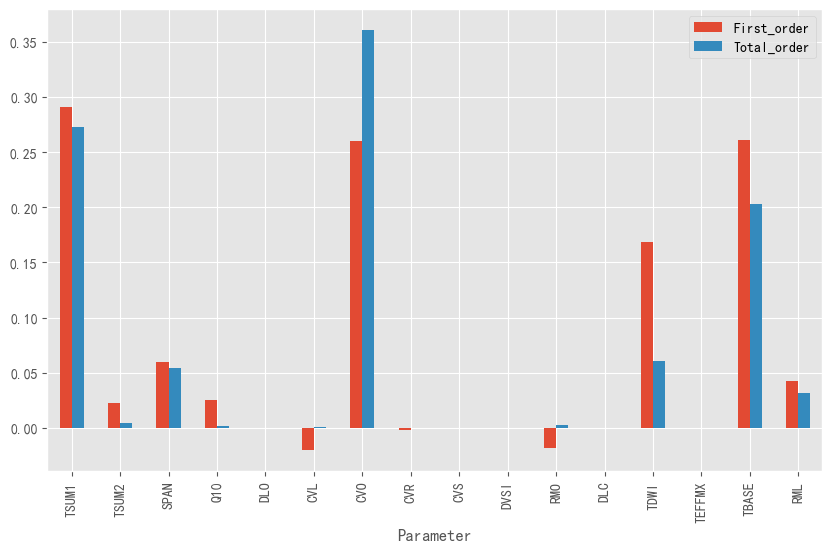

In [49]:
# 创建一个名为df_sensitivity的DataFrame（数据框）对象，用于整理和展示敏感性分析得到的相关结果（参数名称、一阶敏感度和总阶敏感度），方便后续绘图展示。
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]}).set_index("Parameter")
# 以字典形式构建DataFrame，字典的键作为列名，对应的值作为列数据。
# "Parameter"列的数据来源于之前定义的problem字典中的"names"键对应的值，即敏感性分析涉及的各参数名称列表，用于标识每个参数。
# "First_order"列的数据来自于通过Sobol分析得到的结果字典Si中的"S1"键对应的值，这是各参数的一阶敏感度指数列表，反映每个参数单独变化对目标变量方差的影响占比情况。
# "Total_order"列的数据则取自Si字典中的"ST"键对应的值，代表各参数的总阶敏感度指数列表，体现了考虑参数相互作用等情况下对目标变量总方差的影响程度。
# 最后通过set_index方法将"Parameter"列设置为索引列，使得后续绘图等操作时可以基于参数名称更方便地进行展示和对比。

# 创建一个包含一个子图的图表对象（fig）和对应的坐标轴对象（axes），并设置图表的尺寸大小为宽度10单位、高度6单位，为后续在该坐标轴上绘制柱状图做准备。
fig, axes = plt.subplots(figsize=(10,6))
# plt.subplots函数用于创建子图布局，这里只创建了一个子图，返回的第一个值fig代表整个图表对象，第二个值axes代表这个子图对应的坐标轴对象，可通过该对象设置图表的各种属性、绘制图形等。
# figsize参数用于指定图表的尺寸大小，以元组形式传入宽度和高度的数值，此处设置为(10, 6)，单位通常根据具体使用场景和配置来确定，一般可以理解为相对大小或特定绘图库默认的长度单位。

# 使用前面创建的数据框df_sensitivity，在已获取的坐标轴对象（axes）上绘制柱状图（kind="bar"表示绘制柱状图类型），将各参数对应的一阶敏感度和总阶敏感度以柱状图的形式展示出来，
# 方便直观地对比不同参数的敏感度大小以及一阶和总阶敏感度之间的差异，进而分析参数对目标变量的影响情况和相互作用情况。
df_sensitivity.plot(kind="bar", ax=axes)

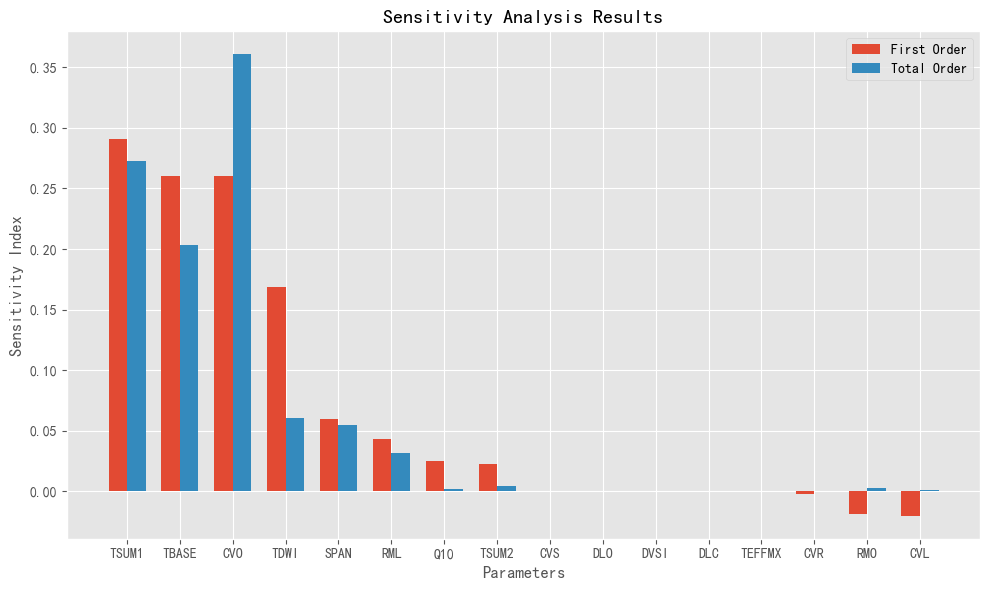

In [50]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # 假设 Si 是 Sobol 分析的结果字典，problem 是定义问题的字典
# # 示例数据，实际应用中应替换为真实数据
# Si = {
#     'S1': [0.25, 0.45, 0.3],
#     'ST': [0.35, 0.6, 0.4]
# }
# problem = {
#     'names': ['param1', 'param2', 'param3']
# }

# 创建 DataFrame 并设置 "Parameter" 列为索引
df_sensitivity = pd.DataFrame({
    "Parameter": problem["names"],
    "First_order": Si["S1"],
    "Total_order": Si["ST"]
}).set_index("Parameter")

# 按 'First_order' 和 'Total_order' 排序，均按降序排列
df_sorted = df_sensitivity.sort_values(by=['First_order', 'Total_order'], ascending=[False, False])

# 创建一个包含一个子图的图表对象（fig）和对应的坐标轴对象（axes）
fig, ax = plt.subplots(figsize=(10, 6))

# 绘制双柱状图，分别表示一阶敏感度和总阶敏感度
bar_width = 0.35
index = df_sorted.index  # 索引作为 x 轴标签

# 绘制一阶敏感度柱状图
bars1 = ax.bar(index, df_sorted['First_order'], bar_width, label='First Order')

# 绘制总阶敏感度柱状图，偏移 bar_width 以便并排显示
bars2 = ax.bar([p + bar_width for p in range(len(index))], df_sorted['Total_order'], bar_width, label='Total Order')

# 设置图表标题和标签
ax.set_xlabel('Parameters')
ax.set_ylabel('Sensitivity Index')
ax.set_title('Sensitivity Analysis Results')
ax.set_xticks([p + bar_width / 2 for p in range(len(index))])
ax.set_xticklabels(df_sorted.index)
ax.legend()

# 自动调整布局以防止标签被截断
plt.tight_layout()

# 显示图表
plt.show()

## 二阶敏感度
二阶敏感度涉及两个参数的综合敏感度。因此，其结果通过矩阵来可视化呈现最为简便。

In [51]:
# Show second-order sensitivities
# 以下代码用于展示二阶敏感度相关信息。二阶敏感度反映了两个参数相互作用对目标变量产生的影响情况，展示它有助于更全面地了解模型中参数间的复杂关系。

second_order = np.array(Si['S2'])
# 从通过Sobol分析得到的结果字典Si中提取'S2'键对应的值，该值代表二阶敏感度相关的数据（通常是一个多维数组等合适的数据结构，具体取决于分析的参数数量等情况），
# 然后将其转换为NumPy数组形式并赋值给second_order变量，方便后续进行数据处理和展示操作，NumPy数组在数值计算和数据操作方面提供了更高效便捷的功能。

pd.DataFrame(second_order, index=problem["names"], columns=problem["names"])
# 使用pandas库的DataFrame函数，以second_order（二阶敏感度数据）为数据内容创建一个数据框对象。
# 通过index参数指定数据框的行索引为problem字典中"names"键对应的值，也就是敏感性分析涉及的各参数名称列表，使得每行对应一个参数名称。
# 同时，通过columns参数指定列索引同样为problem["names"]，也就是让每列也对应一个参数名称，这样构建出的二维数据框结构，其每个单元格的值代表了对应行和列两个参数相互作用的二阶敏感度数值，
# 方便以表格形式直观地查看和分析不同参数两两组合的二阶敏感度情况，不过这行代码只是创建了数据框，若要完整展示可能还需要进一步的输出或者绘图等操作（比如在Jupyter Notebook环境中直接显示这个数据框等）。

,TSUM1,TSUM2,SPAN,Q10,DLO,CVL,CVO,CVR,CVS,DVSI,RMO,DLC,TDWI,TEFFMX,TBASE,RML
TSUM1,NaN,-0.070571,-0.041425,-0.072767,-0.055452,-3.896858e-02,-0.094648,-5.474863e-02,-5.529857e-02,-0.055452,-4.881629e-02,-0.055452,-0.055459,-0.055452,4.627095e-02,-0.074006
TSUM2,NaN,NaN,-0.002675,-0.009256,-0.007565,-6.039204e-03,0.002558,-7.666902e-03,-7.103913e-03,-0.007565,-7.501497e-03,-0.007565,-0.016616,-0.007565,-1.761034e-02,-0.013891
SPAN,NaN,NaN,NaN,0.004576,0.007656,7.811524e-03,0.024475,7.137789e-03,6.684501e-03,0.007656,1.129186e-02,0.007656,-0.017106,0.007656,-1.736534e-02,-0.020194
Q10,NaN,NaN,NaN,NaN,-0.019102,-1.845520e-02,-0.008971,-1.898617e-02,-1.920240e-02,-0.019102,-1.892042e-02,-0.019102,-0.024253,-0.019102,-2.940611e-02,-0.020609
DLO,NaN,NaN,NaN,NaN,NaN,-3.469447e-18,0.000000,4.336809e-19,4.228388e-18,0.000000,6.938894e-18,0.000000,0.000000,0.000000,-5.551115e-17,0.000000
CVL,NaN,NaN,NaN,NaN,NaN,NaN,0.008821,3.092088e-03,2.952304e-03,0.003053,2.631110e-03,0.003053,0.008631,0.003053,8.808742e-03,0.008913
CVO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.342757e-01,2.333933e-01,0.233984,2.407259e-01,0.233984,0.131192,0.233984,3.475912e-01,0.187871
CVR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.769242e-03,0.002769,2.763496e-03,0.002769,0.001907,0.002769,1.464897e-03,0.002644
CVS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001660,-1.527816e-03,-0.001660,-0.001157,-0.001660,-1.371837e-03,-0.001547
DVSI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.938894e-18,0.000000,0.000000,0.000000,-5.551115e-17,0.000000


或者通过一张图像以图形化方式展示矩阵中的数值。从结果来看，很明显二阶相互作用较小，因为所有指数的值都小于0.1。

C:\Users\Administrator\AppData\Local\Temp\ipykernel_1704\809626419.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  r = aximage.axes.set_yticklabels([""] + problem["names"])


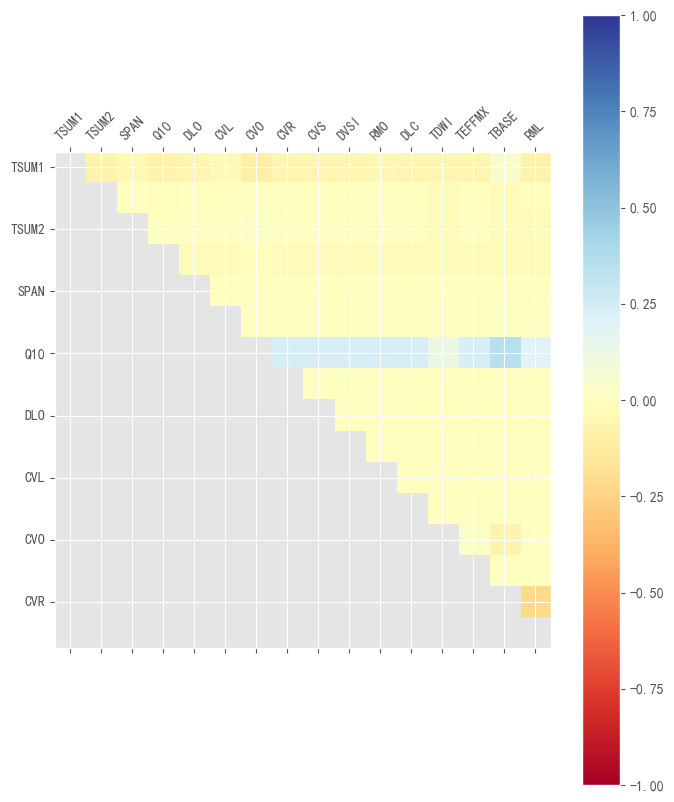

In [52]:
# Visualise second-order sensitivities
# 此行注释说明下面代码的目的是对二阶敏感度进行可视化展示，通过图形的方式呈现二阶敏感度相关数据，以便更直观地观察各参数之间二阶相互作用的情况。

fig, axes = plt.subplots(figsize=(8, 10))
# 使用plt.subplots函数创建一个新的图形（fig）对象以及对应的坐标轴（axes）对象，其中figsize参数设置图形的尺寸大小为宽度8个单位、高度10个单位，
# 这里创建的图形对象和坐标轴对象将作为后续绘制二阶敏感度可视化图形以及添加相关元素（如颜色条、刻度标签等）的基础框架。

aximage = axes.matshow(second_order, vmin=-1.0, vmax=1.0, cmap="RdYlBu")
# 在已获取的坐标轴（axes）上调用matshow函数来展示二阶敏感度数据（second_order，之前已准备好的包含二阶敏感度数值的数组等合适数据结构），
# 通过vmin和vmax参数分别指定颜色映射的最小值为 -1.0，最大值为1.0，这意味着二阶敏感度数值将依据这个范围被映射到对应的颜色上，数值越小颜色越接近vmin对应的颜色，数值越大越接近vmax对应的颜色；
# cmap参数指定使用"RdYlBu"（红-黄-蓝）颜色映射方案，这种颜色映射方式常用于呈现有正负值且需要直观对比大小的数值情况，通过颜色变化可以清晰地看出二阶敏感度数值在不同参数组合下的大小及分布情况，
# 该函数调用返回的aximage对象可用于后续进一步操作这个矩阵可视化图形（比如设置图形属性等）。

cbar = fig.colorbar(aximage)
# 针对前面绘制的二阶敏感度矩阵可视化图形（aximage），在整个图形（fig）对象上添加一个颜色条（colorbar）。颜色条的作用是作为一个可视化的辅助工具，
# 它能清晰地展示出颜色与数值之间的对应关系，使得查看矩阵图时可以根据颜色快速判断出二阶敏感度数值的大致范围，增强可视化展示的可读性和可解释性。

aximage.axes.set_xticks(range(len(problem["names"])))
# 对二阶敏感度矩阵可视化图形（aximage）的x轴进行刻度设置。通过调用set_xticks函数，并传入基于问题参数（problem）中"names"列表长度生成的刻度位置范围（range(len(problem["names"]))），
# 使得x轴上的刻度数量与参与敏感性分析的参数个数保持一致，为下一步正确添加参数名称作为x轴刻度标签做准备，确保每个参数都能有对应的刻度位置来显示其标签。

aximage.axes.set_xticklabels(problem["names"], rotation=45)
# 为二阶敏感度矩阵可视化图形（aximage）的x轴刻度添加对应的标签。将问题参数（problem）中"names"里的各个参数名称作为标签内容（这样每个刻度位置就能对应一个具体的参数），
# 同时设置标签旋转45度，这样做是为了避免由于参数名称可能较长而在x轴上产生标签文字相互重叠的情况，保证每个参数名称都能清晰地展示出来，方便查看和将可视化图形与实际的参数对应起来。

r = aximage.axes.set_yticklabels([""] + problem["names"])
# 为二阶敏感度矩阵可视化图形（aximage）的y轴刻度设置标签。先将一个空字符串添加到问题参数（problem）中"names"列表的开头，然后以此列表作为y轴刻度标签进行设置，
# 这样做的目的可能是出于可视化布局或者与矩阵数据行列对应关系等方面的考虑，使得y轴标签与二阶敏感度矩阵数据的展示逻辑更加契合，便于直观地观察和解读不同参数之间的二阶敏感度情况，
# 该操作返回的r变量可能包含了此次设置y轴刻度标签操作的一些相关结果信息（具体取决于函数内部实现机制），不过通常在这个场景下可能并不一定需要直接使用这个返回值。

## 解释
甜菜产量对有效积温（TSUM1）敏感的背景与以下事实相关：较大的有效积温（TSUM1）意味着作物将在营养生长阶段停留更长时间。鉴于收获日期是固定的，这就意味着甜菜根积累糖分的可用时间会缩短，因此模拟得出的产量就会更低。显然，分析中涉及的其他参数在所选定的取值范围内并没有产生很大影响，所以就敏感度而言，有效积温（TSUM1）相较于其他参数占主导地位。 

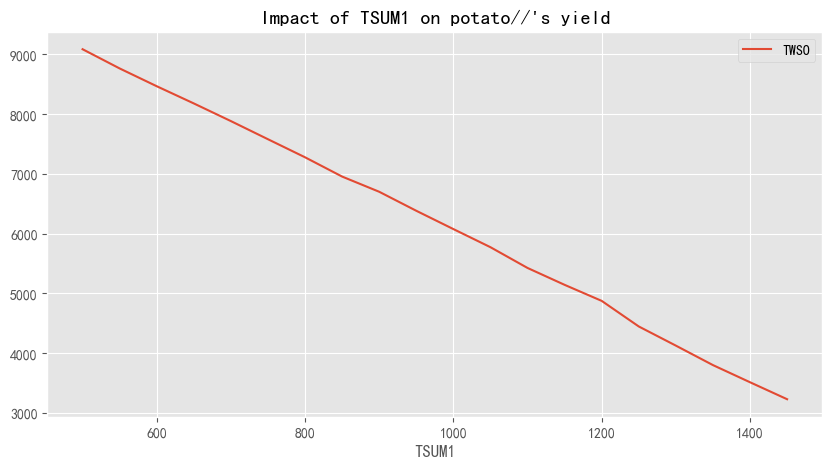

In [63]:
TSUM1_values = list(range(500, 1050, 50))
# 创建一个名为TSUM1_values的列表，通过使用range函数生成一个从500到799（不包含800，因为range函数的特性是左闭右开区间）、步长为50的整数序列，
# 并将其转换为列表形式。这个列表中的值将作为TSUM1参数后续要设置的不同取值，用于单独探究该参数变化对甜菜产量的影响。

results = []
# 创建一个空列表results，用于存储在不同TSUM1取值下运行模型后得到的目标变量（即甜菜产量相关指标，由前面定义的target_variable指定）的结果，方便后续整理和分析数据。
cropcalendar = agro_dict[0][firstkey]['CropCalendar'] 
# 通过前面获取的键，从agro数据结构中提取出作物种植日历（CropCalendar）相关的详细信息，这些信息包含了作物名称、品种、生长起止时间等关键内容，对于后续配置模型很重要。

cropname=cropcalendar['crop_name']
for tsum1 in TSUM1_values:
    # 开始对TSUM1_values列表进行循环遍历，每次循环取出一个TSUM1的取值（tsum1变量），用于设置模型参数并运行模型，观察对应的产量结果变化。
    parameters.clear_override()
    # 调用params对象（应该是与模型参数管理相关的对象，比如之前提到的ParameterProvider类的实例等）的clear_override方法，
    # 清除之前可能设置的所有参数覆盖值，确保每次循环时参数处于初始干净的状态，避免之前的设置对本次循环产生干扰。

    parameters.set_override("TSUM1", tsum1)
    # 使用params对象的set_override方法，将名为"TSUM1"的参数设置为当前循环中取出的tsum1值，也就是依次将TSUM1参数设置为TSUM1_values列表中的不同取值，
    # 以此来单独考察该参数变化对模型结果（甜菜产量）的影响情况。

    wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict)
    # 使用更新后的参数（params）、气象数据提供者（wdp）以及农业管理信息（agro）实例化一个WOFOST 72_PP模型对象wofost，准备运行该模型实例，
    # 以模拟在当前TSUM1参数取值下的甜菜生长情况，进而获取对应的产量结果。

    wofost.run_till_terminate()
    # 调用wofost对象的run_till_terminate方法，运行WOFOST模型直到满足终止条件，这个过程中模型会根据设定的参数、气象数据以及农业管理情况模拟甜菜从开始到结束的整个生长过程，
    # 最终得到相应的模拟结果。

    r = wofost.get_summary_output()
    # 调用wofost对象的get_summary_output方法，获取模型运行结束后的汇总输出结果，这个结果可能包含了多个与甜菜生长相关的指标信息，以某种数据结构（比如字典、列表嵌套等形式）返回。

    results.append(r[0][target_variable])
    # 从模型的汇总输出结果（r）中提取出目标变量（target_variable，之前定义的与甜菜产量相关的那个变量）的值，这里假设r的结构中第一层索引为0（具体结构需结合模型实际返回情况确定），
    # 然后将该值添加到results列表中，不断积累不同TSUM1取值下对应的甜菜产量结果，为后续的数据分析和可视化展示做准备。

df = pd.DataFrame({"TSUM1": TSUM1_values,
                   target_variable: results}
                 ).set_index("TSUM1")
# 使用pandas库的DataFrame函数创建一个数据框（df）对象，以字典形式传入数据，字典的键作为列名，对应的值作为列数据。
# 其中"TSUM1"列的数据就是前面生成的TSUM1参数的不同取值列表（TSUM1_values），另一列使用之前定义的目标变量名（target_variable）作为列名，对应的数据是之前循环收集到的不同TSUM1取值下的甜菜产量结果列表（results），
# 最后通过set_index方法将"TSUM1"列设置为索引列，方便后续基于TSUM1取值来查看和分析对应的甜菜产量情况，例如绘制图表时可以以TSUM1为横坐标进行展示。

r = df.plot(title=f"Impact of TSUM1 on {cropname}'s yield", figsize=(10,5))
# 调用数据框（df）对象的plot方法，绘制图表来展示TSUM1参数变化对甜菜产量的影响情况。通过title参数设置图表的标题为"Impact of TSUM1 on sugar beet yield"（表明展示的是TSUM1对甜菜产量的影响），
# 并使用figsize参数设置图表的尺寸大小为宽度10单位、高度5单位，绘制完成后返回的结果（通常包含绘图相关的一些信息，具体取决于绘图函数实现细节）赋值给变量r，
# 这样可以在合适的环境（比如Jupyter Notebook等）中展示出绘制好的图表，直观地呈现出TSUM1与甜菜产量之间的关系。

# 加速样本模拟
当要对许多变量进行敏感性评估时，遍历样本很快就会变成一个漫长的过程。不过，由于对每个样本的模拟都是相互独立的，我们可以通过在多个中央处理器（CPU）上运行来轻松加快模拟速度。Python提供了“multiprocessing”（多进程）模块，用于启动一组工作进程来执行模拟任务。

在Jupyter Notebook中演示“multiprocessing”模块的使用是比较复杂的，因为Notebook的基础架构并不支持它。因此，我们提供了一个独立的Python脚本，该脚本使用顺序处理和并行处理执行的计算与本Notebook中的计算完全相同。可以从[此处](SA_mp_example.py)下载该脚本。 

## 3 Visualize output
All state variables in WOFOST 7.2 are also present in WOFOST 8.1. For instance, we can plot the total dry matter, tuber dry weight and leaf area index:

## 3 输出可视化
WOFOST 7.2中的所有状态变量在WOFOST 8.1中同样存在。例如，我们可以绘制总干物质、块茎干重以及叶面积指数的图表。

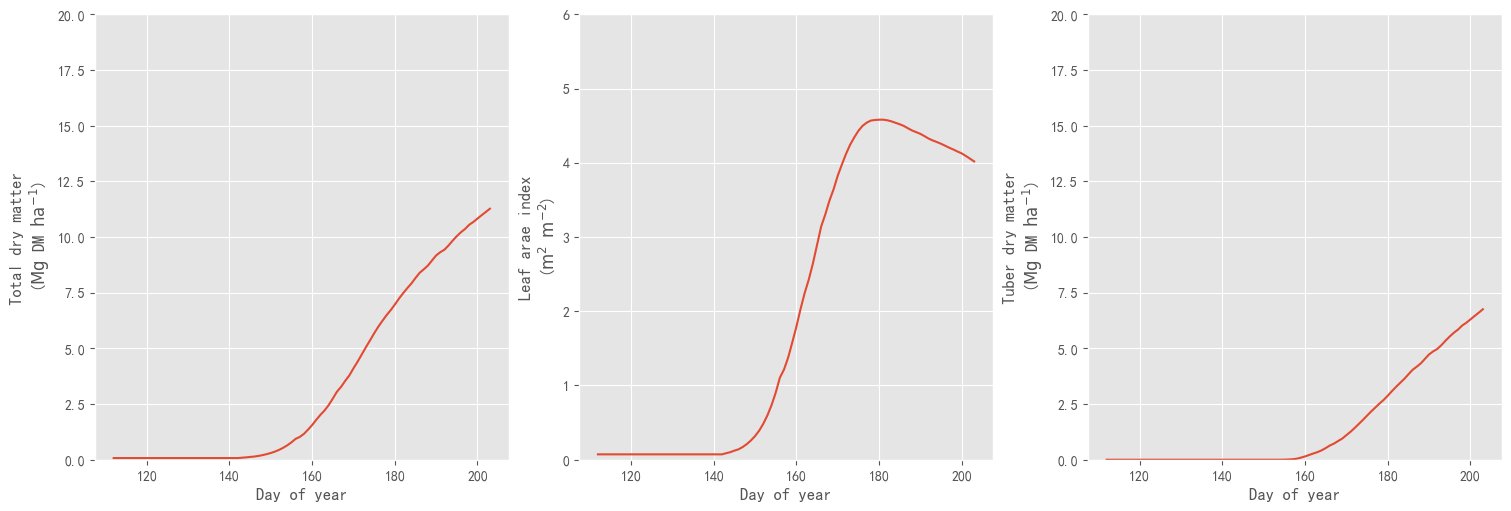

In [54]:
# 从名为w81_plotting的模块中导入名为plot_w72_variables的函数。
# 从函数名推测，其功能大概率是用于绘制在WOFOST 7.2版本中相关变量的可视化图形，
# 虽然当前使用的是WOFOST 8.1版本，但由于文中提到8.1版本包含了7.2版本的所有状态变量，所以可以利用这个函数来绘制那些特定变量的图形，
# 并且该函数应该会依据传入的数据（此处为df_output，通常是包含模型输出结果的DataFrame格式数据）来提取相应的变量信息进行绘图操作，
# 以便直观展示如总干物质、块茎干重、叶面积指数等相关变量随时间或其他因素变化的趋势及情况。
from w81_plotting import plot_w72_variables  

# 调用plot_w72_variables函数，并传入df_output（前面通过将WOFOST 8.1模型运行的输出结果转换得到的DataFrame数据结构，
# 其中包含了多个状态变量的数据信息）作为参数。函数执行后会返回一个图形对象（可能是matplotlib的Figure对象等），
# 并将其赋值给fig变量，这样后续可以对该图形进行进一步操作，比如保存、展示等操作（虽然此处后续代码未体现相关进一步操作内容），
# 其目的就是通过调用这个函数来生成包含特定变量可视化展示的图形，便于直观分析模型模拟结果所反映的实际情况。
fig = plot_w72_variables(df_output)

Finally, the addition of SNOMIN and the layered waterbalance also introduced various layer specific state variable. These are the soil moisture contents, the amounts of ammonium-N and the amounts of nitrogen-N per soil layer (see below). 

The figure for the NH4 amount in the top layers starts at 5 kg/ha (actually the value of NH4I in the site parameters) and then rapidly increases to around 70 kg/ha due to a fertilization event. The amount of NO3 starts at 30 kg/ha (parameter NO3I) and then rapidly increases to 90 kg/ha due to fertilization. Next, the amount of NH4 rapid decreases due to the conversion of NH4 to NO3 (nitrification) and consequently the amount of NO3 increases. This patterns repeats itself for a second fertilization event around day 125.

From day 150 onward the potato crop starts taking up N rapidly leading to steap decrease in N availability. A final fertilizer event around day 170 then adds some NO3/NH4 but the total N amount is rapidly depleated until day 260 when the crop cycle is finished. 

In this example, the crop is able to take up all N from the soil with little leaching of N towards lower layers.

最后，SNOMIN（某种与氮素相关的模块，需结合前文确定具体指代）以及分层水量平衡的加入也引入了各种针对不同土层的特定状态变量。这些变量包括各土层的土壤含水量、铵态氮含量以及硝态氮含量（见下文）。

表层土壤中铵态氮含量的图表起始值为5千克/公顷（实际上就是场地参数中NH4I的值），随后由于一次施肥事件，其含量迅速增至约70千克/公顷。硝态氮含量起始值为30千克/公顷（参数NO3I的值），接着因施肥迅速增加到90千克/公顷。接下来，由于铵态氮向硝态氮的转化（硝化作用），铵态氮含量迅速下降，相应地，硝态氮含量随之增加。在大约第125天的第二次施肥事件时，这种变化模式再次出现。

从第150天起，马铃薯作物开始快速吸收氮素，导致氮素有效性急剧下降。在大约第170天的最后一次施肥事件会补充一些硝态氮/铵态氮，但总氮量会迅速减少，直至第260天作物生长周期结束时消耗殆尽。

在这个示例中，作物能够从土壤中吸收所有的氮素，仅有少量氮素向底层土壤淋溶。 

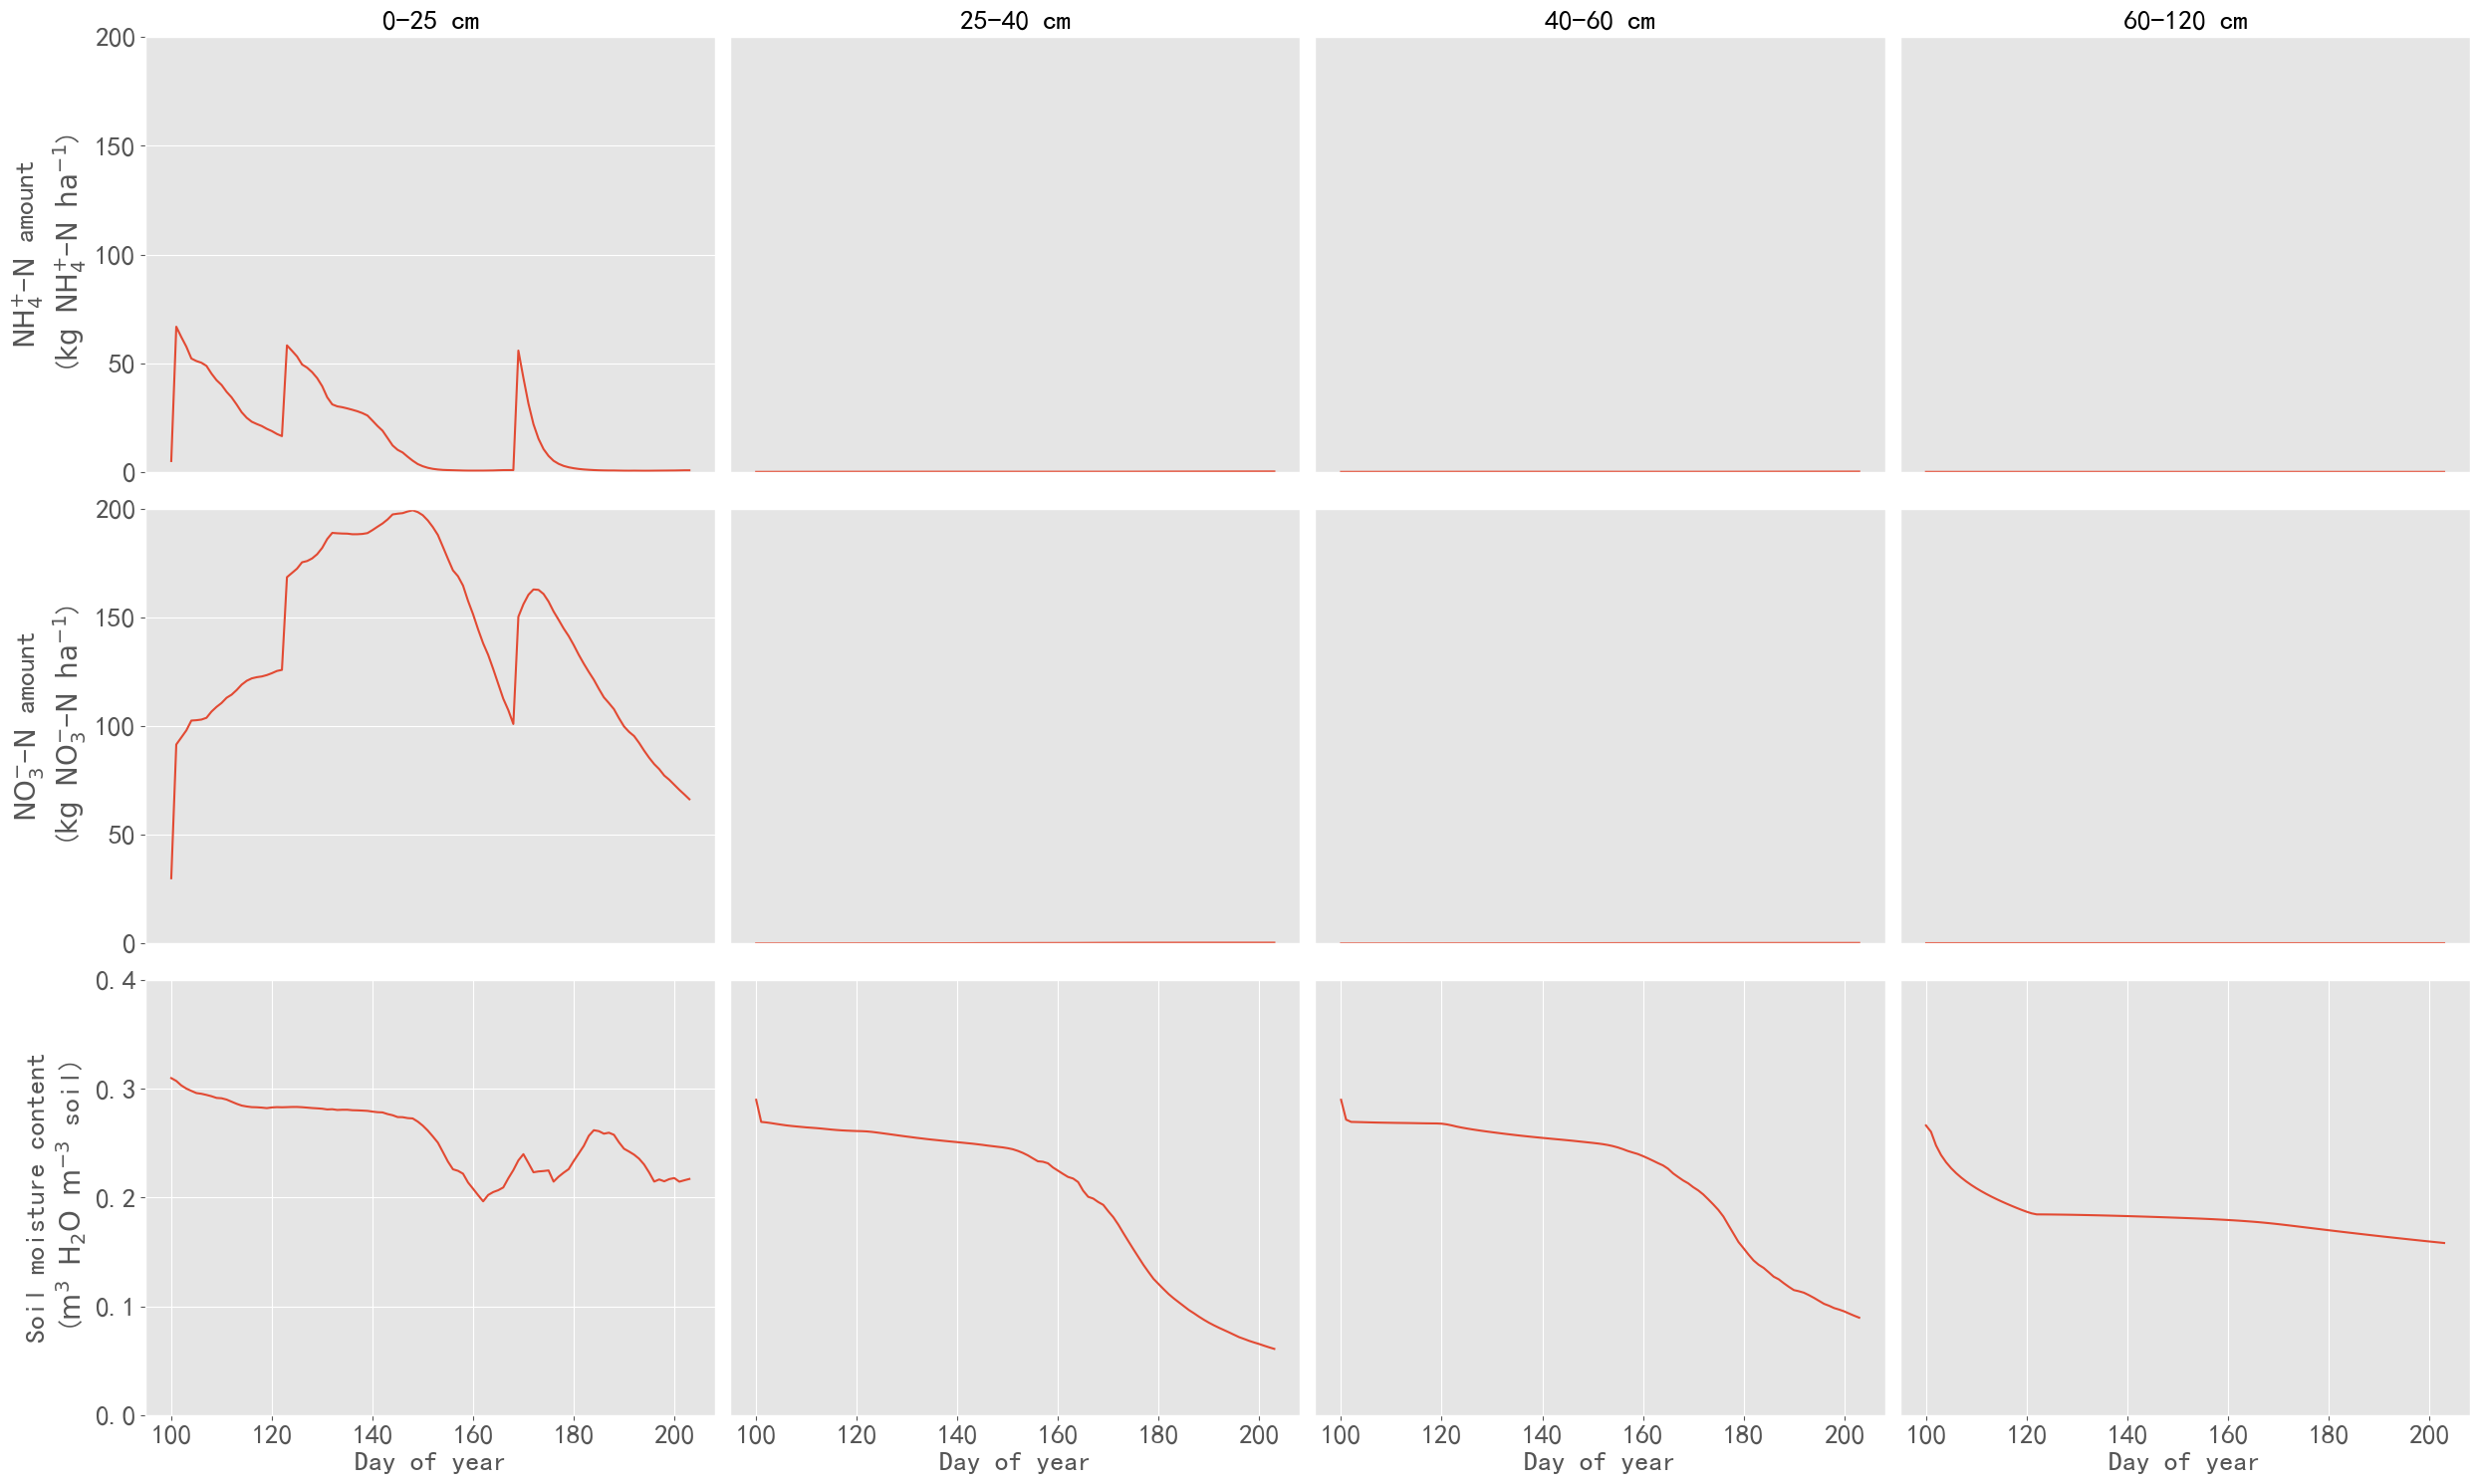

In [55]:
# 从名为w81_plotting的模块中导入名为plot_w81_soil_variables的函数。
# 从函数名推测，其功能应该是用于绘制WOFOST 8.1版本中与土壤相关变量的可视化图形，
# 该函数会依据传入的参数来提取相应的土壤变量信息（比如各土层的土壤含水量、氮素含量等，结合前文提到的相关内容）进行绘图操作，
# 并且会利用土层厚度等信息（可能用于区分不同土层在图中的展示等作用）来生成直观展示土壤相关状态变量随时间或其他因素变化趋势及情况的图表，
# 方便查看不同土层的这些变量之间的差异以及变化规律，进而分析土壤内部的物质变化过程等情况。
from w81_plotting import plot_w81_soil_variables  

# 调用plot_w81_soil_variables函数，并传入df_output（前面通过WOFOST 8.1模型运行得到的输出结果转换而成的DataFrame数据结构，
# 其中包含了如土壤相关变量等各种状态变量的数据信息）以及Thickness（应该是之前定义好的表示各土层厚度的列表或数组等数据结构，
# 用于在绘图时体现不同土层的特征，辅助区分各土层相关变量的情况）这两个参数。
# 函数执行后会返回一个图形对象（可能是matplotlib的Figure对象等），并将其赋值给fig变量，
# 以便后续可以对该图形进行进一步操作，例如将图形保存下来、在合适的界面展示等（不过此处后续代码并没有体现这些进一步的操作内容），
# 其目的在于通过调用该函数并传入相应参数来生成展示土壤相关变量的可视化图形，便于直观地对模型模拟结果中土壤部分的数据进行分析和理解。
fig = plot_w81_soil_variables(df_output, Thickness)

In addition, various state variables have been added to WOFOST 8.1 that describe the N state of the crop. For instance, WOFOST 8.1 is now capable of simulating the amount of N in crop organs:

此外，WOFOST 8.1中新增了各种描述作物氮素状态的状态变量。例如，WOFOST 8.1现在能够模拟作物器官中的氮含量。

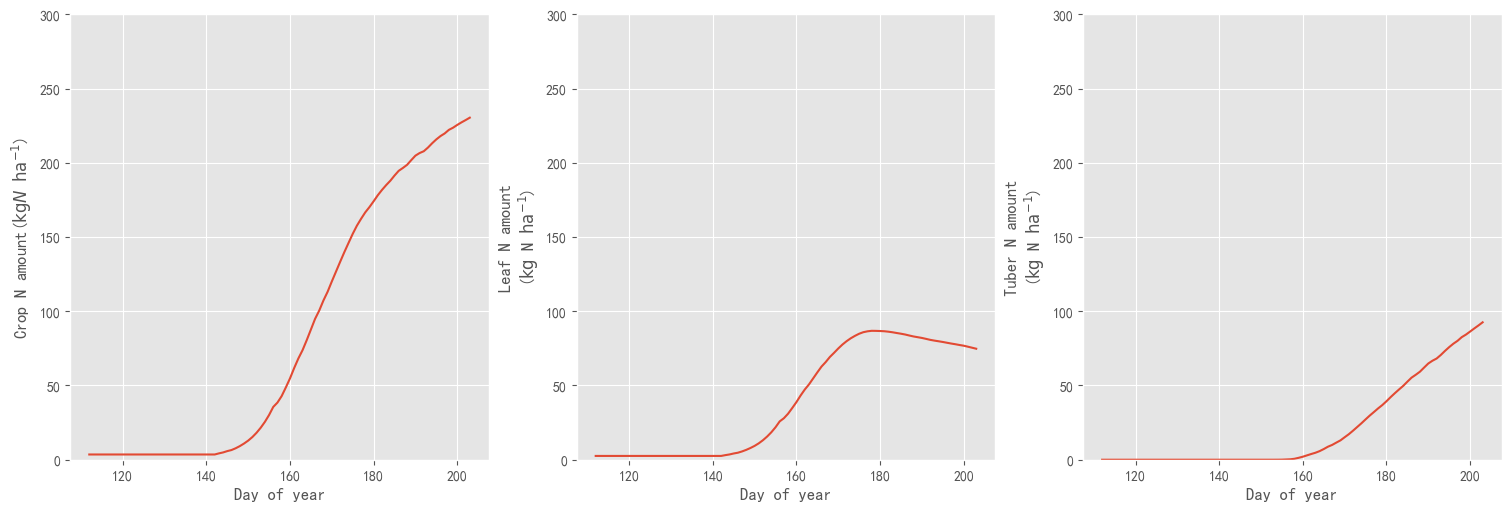

In [56]:
# 从名为w81_plotting的模块中导入名为plot_w81_crop_variables的函数。
# 从函数名可推测出其功能是用于绘制WOFOST 8.1版本中与作物相关变量的可视化图形，
# 它会依据传入的df_output（即之前通过WOFOST 8.1模型运行后得到的输出结果转换而成的DataFrame数据结构，
# 其中包含了众多描述作物各方面状态的变量数据信息）来提取相应的作物变量数据，
# 进而绘制出能直观展示作物相关状态变量（比如作物器官中的氮含量、叶面积指数、干物质积累量等各种前面提到的作物相关状态对应的变量）
# 随时间或其他因素变化趋势及情况的图表，方便查看作物在整个生长周期内不同方面状态的变化规律以及相互关系等，有助于分析作物生长状况。
from w81_plotting import plot_w81_crop_variables  

# 调用plot_w81_crop_variables函数，并传入df_output作为参数。函数执行后会返回一个图形对象（可能是matplotlib的Figure对象等），
# 然后将这个图形对象赋值给fig变量，如此一来，后续就可以根据实际需求对该图形进行进一步的操作，
# 例如将图形保存为图片文件以便后续查看、在合适的图形界面进行展示让使用者直观了解作物相关变量的变化情况等（不过此处后续代码并没有体现这些进一步操作的内容），
# 其核心目的就是借助调用这个函数来生成能够展示作物相关变量的可视化图形，从而更方便地对WOFOST 8.1模型模拟出的作物相关结果进行直观分析与深入理解。
fig = plot_w81_crop_variables(df_output)

And the total amounts of $\mathrm{NH}_4^{+}$-$\mathrm{N}$, $\mathrm{kg}$ $\mathrm{NO}_3^{-}$-$\mathrm{N}$, and water are shown below. Given that most of the N remains in the upper layers, the figure for NO3/NH4 below are similar to the figures already shown for layer 1.

铵态氮（$\mathrm{NH}_4^{+}$-$\mathrm{N}$）、硝态氮（$\mathrm{kg}$ $\mathrm{NO}_3^{-}$-$\mathrm{N}$）以及水分的总量展示如下。鉴于大部分氮素仍留存于上层土壤中，下方展示的硝态氮/铵态氮相关图表与之前已展示的第1层土壤的图表情况相似。 

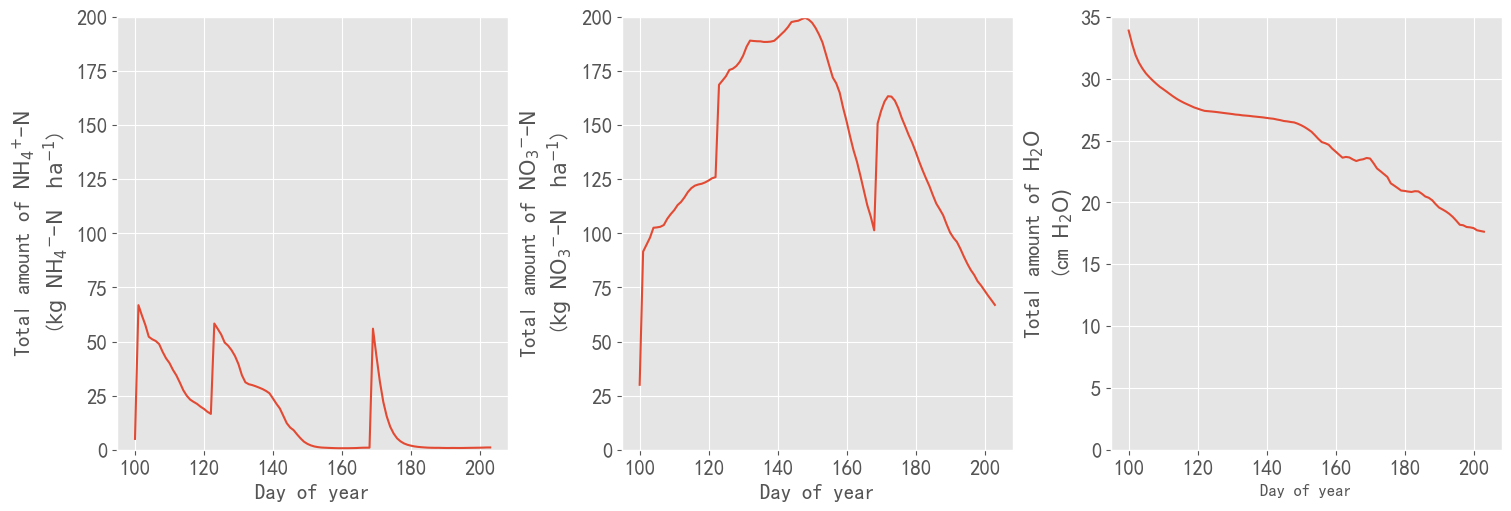

In [57]:
# 从名为w81_plotting的模块中导入名为plot_w81_soil_totals的函数。
# 从函数名推测，其功能大概率是用于绘制WOFOST 8.1版本中与土壤相关总量数据的可视化图形，
# 比如各土层中铵态氮、硝态氮以及水分等总量情况的图表，它会基于传入的相关参数来获取对应的数据信息进行绘图操作，
# 以此直观展示土壤各方面总量数据随时间或者其他因素变化的趋势及情况，方便分析土壤整体的物质含量和水分变化规律等。

from w81_plotting import plot_w81_soil_totals  

# 调用plot_w81_soil_totals函数，并传入三个参数。
# df_output参数是之前通过WOFOST 8.1模型运行所得到的输出结果转换而成的DataFrame数据结构，
# 其中包含了土壤相关变量等众多模拟结果的数据信息，函数会从中提取出绘制土壤总量相关图形所需的数据，比如各土层不同物质总量的时间序列数据等。
# Thickness参数应该是之前已经定义好的表示各土层厚度的数据结构（可能是列表、数组等形式），
# 该参数在绘图过程中可能用于辅助体现不同土层的特征，例如根据土层厚度来合理划分图表中的不同土层区间展示，或者在计算各土层总量相关指标时作为权重等参考因素。
# nlayers参数表示土壤的总层数，它可以帮助函数明确需要处理的土层数量范围，便于准确地对各土层的总量数据进行汇总、绘图等操作，
# 例如循环遍历各土层来统计相应物质的总量情况并绘制到图形中。

# 函数执行后会返回一个图形对象（可能是matplotlib的Figure对象等），并将其赋值给fig变量，
# 这样后续就可以针对这个图形对象进行进一步的操作，比如将图形保存为图片文件以便后续查看分析、在合适的展示界面展示该图形让使用者直观了解土壤总量相关数据的变化情况等（不过此处后续代码未体现这些进一步操作内容），
# 其主要目的就是通过调用这个函数并传入相应参数来生成能够清晰展示土壤各相关总量变量变化的可视化图形，便于更好地对WOFOST 8.1模型模拟出的土壤相关结果进行直观分析和整体把握。

fig = plot_w81_soil_totals(df_output, Thickness, nlayers)

## 打印DataFrame（即df_output）的末尾几行数据
比如查看模型输出结果在最后几个时间步长下各变量的取值情况，便于初步了解数据的大致范围和最终状态等信息。
print(df_output.tail())  


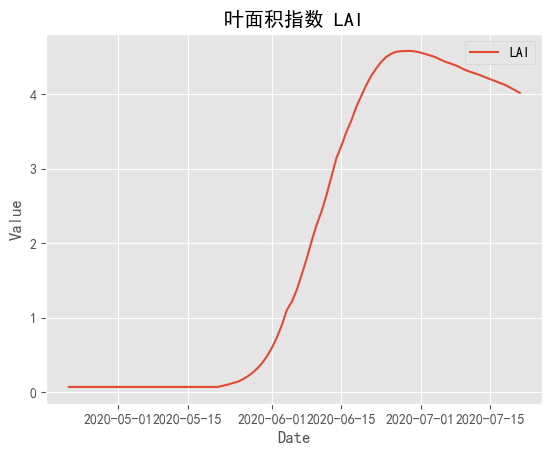

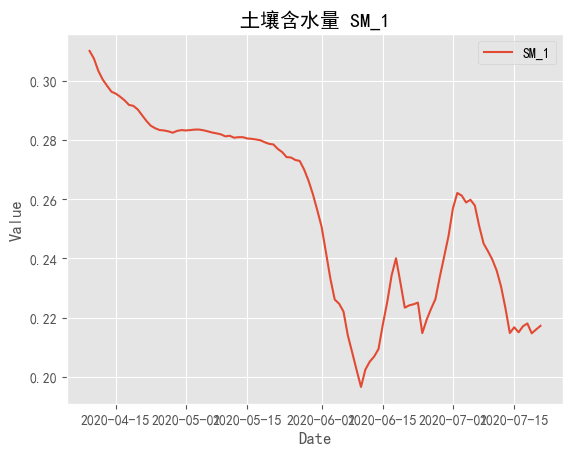

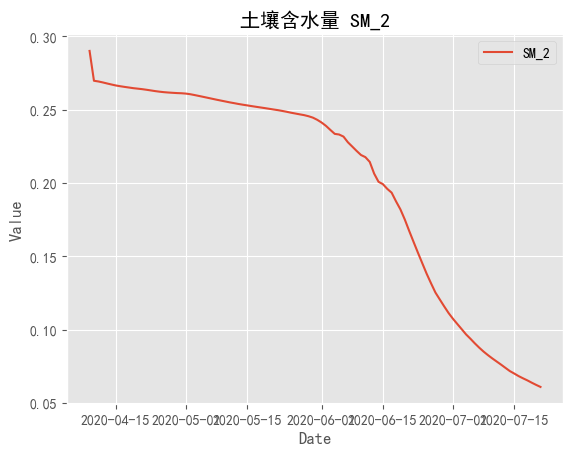

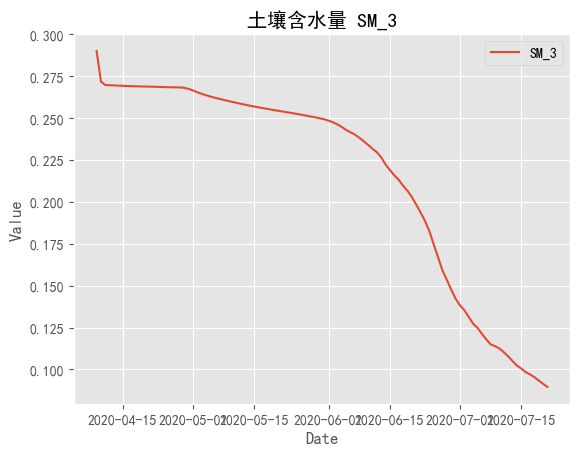

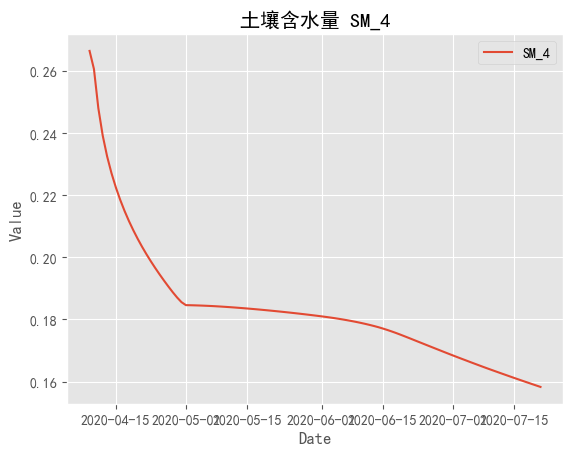

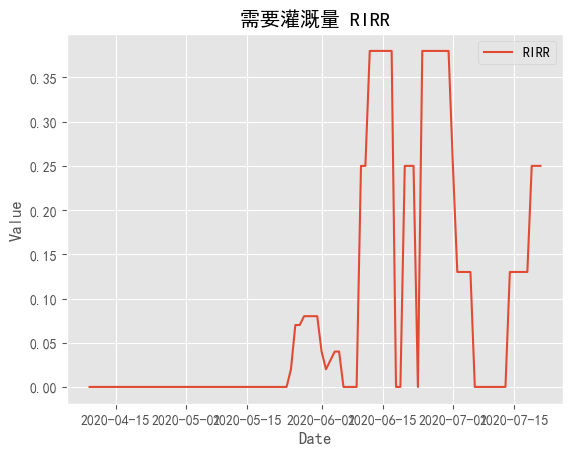

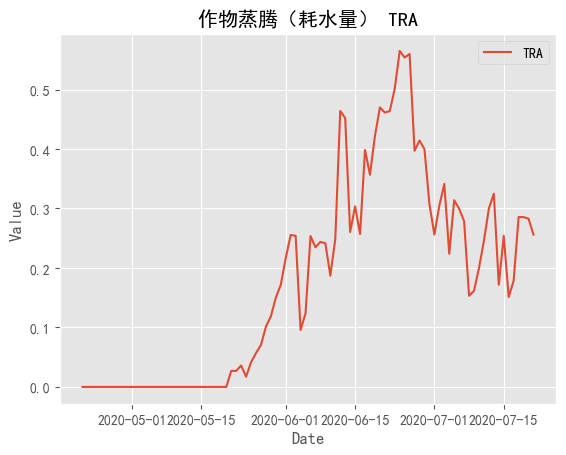

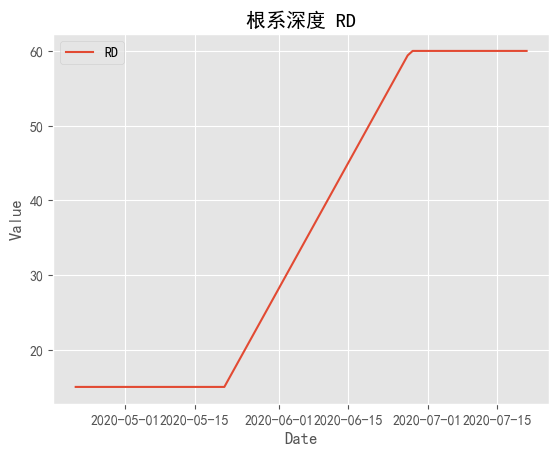

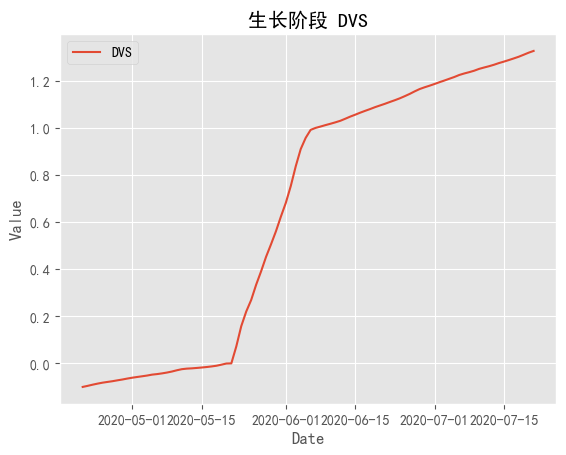

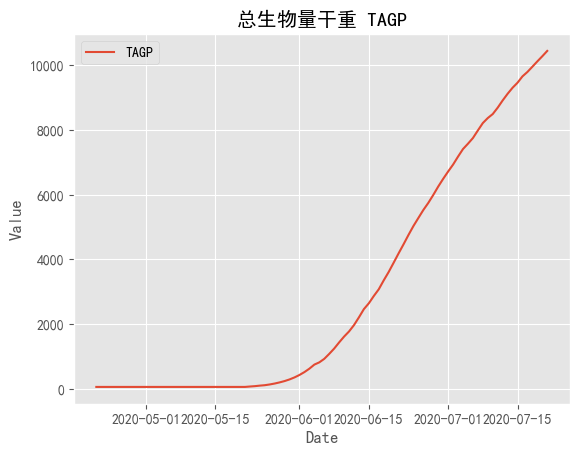

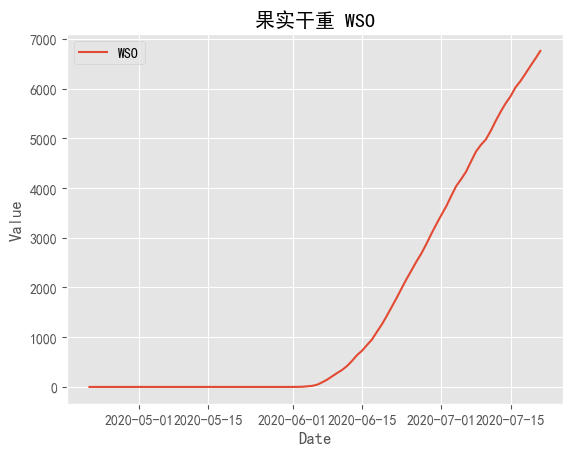

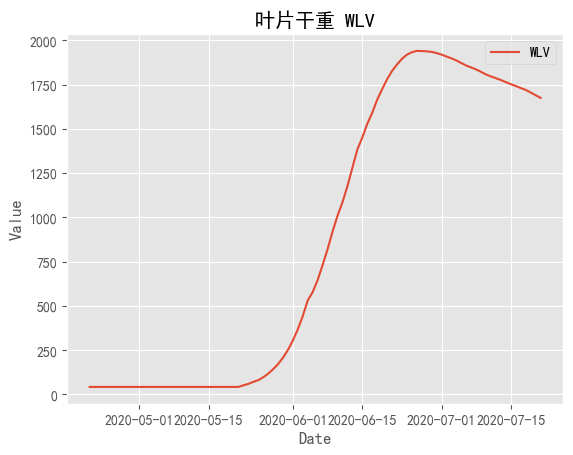

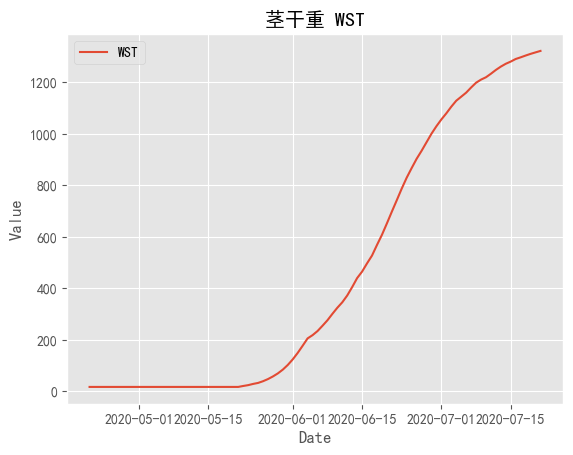

In [58]:

# 这行代码存在语法错误，正确的用法应该是通过类似df_output['列名']的方式来访问DataFrame中的某一列数据，
# 此处可能是想获取名为'SM'的列数据，但写法不符合规范，无法正确执行，需要修正为正确的列索引方式才能达到预期目的，
# 比如如果'SM'是代表某类数据（可能是土壤湿度相关等）的列名，这样才能提取对应的数据进行后续操作（比如分析、绘图等）。
# df_output('SM')  

# 以下是绘图相关的设置及绘图操作部分的注释

# 使用DataFrame的plot方法绘制叶面积指数（LAI）随时间（'day'列作为横坐标）变化的折线图，
# 并设置图形的标题为"叶面积指数 LAI"，纵坐标标签为"Value"，横坐标标签为"Date"，
# 返回的Axes对象赋值给ax变量，后续可以基于这个ax对象继续对图形进行其他设置（比如添加图例、调整线条样式等），
# 这里通过多次对ax赋值的方式依次绘制多个不同变量的图形，每个图形都会在同一个绘图区域（如果没有额外设置图形布局的话）进行展示。
ax = df_output.plot(x='day', y='LAI', title="叶面积指数 LAI", ylabel="Value", xlabel="Date")  

# 绘制土壤含水量（SM_1代表第一层土壤的含水量，推测后续SM_2、SM_3、SM_4同理代表不同土层的含水量）随时间变化的折线图，
# 设置图形标题、纵坐标标签和横坐标标签，同样将返回的Axes对象赋值给ax变量，方便后续继续调整图形样式等操作。
ax = df_output.plot(x='day', y='SM_1', title="土壤含水量 SM_1", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='SM_2', title="土壤含水量 SM_2", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='SM_3', title="土壤含水量 SM_3", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='SM_4', title="土壤含水量 SM_4", ylabel="Value", xlabel="Date")  

# ax = df_output.plot(x='day', y='SM', title="土壤含水量 SM", ylabel="Value", xlabel="Date")  

# 绘制需要灌溉量（RIRR）随时间变化的折线图，设置相应的图形标题、坐标轴标签，并将Axes对象赋值给ax变量。 rirr rate of irrigation cm/day
ax = df_output.plot(x='day', y='RIRR', title="需要灌溉量 RIRR", ylabel="Value", xlabel="Date")  

# 以下几行代码被注释掉了，说明暂时不执行这部分绘图操作，可能是出于当前不需要展示这些变量图形或者后续会根据情况再决定是否绘制等原因，
# 如果取消注释，就会分别绘制总灌溉量（TOTIRR）、灌溉量（IRRIG）、渗漏量（WBOT，注释中说明了其代表的含义是超出最大可扎根深度且植物无法利用的水量）随时间变化的折线图。
# ax = df_output.plot(x='day', y='TOTIRR', title="总灌溉量 TOTIRR", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='IRRIG', title="灌溉量 IRRIG", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='WBOT', title="渗漏量 WBOT", ylabel="Value", xlabel="Date")  
# WBOT, Water below maximum rootable depth and unavailable for plant growth.  

# 绘制作物蒸腾（耗水量，TRA表示）随时间变化的折线图，设置图形标题、坐标轴标签，并将Axes对象赋值给ax变量，
# 通过绘制这个图形可以直观了解作物在不同时间的蒸腾耗水情况，对于分析作物的水分利用效率等方面有帮助。
ax = df_output.plot(x='day', y='TRA', ylabel="Value", xlabel="Date", title="作物蒸腾（耗水量） TRA")  

# 绘制根系深度（RD）随时间变化的折线图，设置相应的图形属性，便于查看作物根系在整个生长周期内深度的变化趋势，
# 根系深度对于了解作物对土壤不同深度水分和养分的获取能力等方面有着重要意义。
ax = df_output.plot(x='day', y='RD', title="根系深度 RD", ylabel="Value", xlabel="Date")  

# 绘制生长阶段（DVS，可能代表作物发育阶段的某个指标，比如从播种到成熟不同阶段的量化表示）随时间变化的折线图，
# 设置图形的相关标签，通过该图可以清晰看到作物在整个生长周期内所处的发育阶段变化情况，有助于分析作物生长规律。
ax = df_output.plot(x='day', y='DVS', title="生长阶段 DVS", ylabel="Value", xlabel="Date")  

# 绘制总生物量干重（TAGP）随时间变化的折线图，设置图形的标题、坐标轴标签等，
# 总生物量干重是衡量作物生长状况和生产力的一个重要指标，通过这个图形可以直观观察其在整个生长周期内的积累变化过程。
ax = df_output.plot(x='day', y='TAGP', title="总生物量干重 TAGP", ylabel="Value", xlabel="Date")  

# 以下几行代码被注释掉了，和前面类似，暂时不执行绘制果实干重（TWSO、WSO，可能是不同表示方式或不同阶段的果实干重相关变量）、
# 叶片干重（TWLV、WLV）、茎干重（TWST、WST）随时间变化的折线图的操作，可能根据后续实际需求决定是否绘制展示这些作物不同器官干重变化情况的图形。
# wlv
# dry weight of living leaves
# wofost_leaf_dynamics
# kg ha-1

# wso
# dry weight of living storage organs
# wofost_storage_organ_dynamics
# kg ha-1

# wrt
# dry weight of living roots
# wofost_root_dynamics
# kg ha-1

# wst
# dry weight of living stems
# wofost_stem_dynamics
# kg ha-1

# ax = df_output.plot(x='day', y='TWSO', title="果实干重 TWSO", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='TWLV', title="叶片干重 TWLV", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='TWST', title="茎干重 TWST", ylabel="Value", xlabel="Date")  

ax = df_output.plot(x='day', y='WSO', title="果实干重 WSO", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='WLV', title="叶片干重 WLV", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='WST', title="茎干重 WST", ylabel="Value", xlabel="Date")

In [59]:
# 尝试打印DataFrame（即df_output）中名为'SM'列的第一个元素的值。
# 这里的索引方式['SM']是用于选取名为'SM'的列，不过后续的[0][0]这种双重索引的写法需要根据df_output中'SM'列的数据结构来判断是否合理。
# 如果'SM'列的数据存储为多维结构（比如嵌套列表、多维数组等形式），那么这样的索引可能是想获取最内层的第一个元素，
# 但如果数据结构并非如此，可能会导致索引错误，需要进一步确认数据实际结构确保索引的正确性。
print(df_output['SM'][0][0])  

# 打印DataFrame中名为'SM'列的末尾几行数据，通过使用tail()方法可以快速查看'SM'列数据在最后几个时间步长或者记录中的取值情况，
# 便于了解该变量在模拟后期的大致范围、变化趋势等信息，对于分析土壤含水量（假设'SM'代表土壤含水量）等随时间的变化情况有一定帮助。
print(df_output['SM'].tail())  

# 打印整个DataFrame（df_output）的末尾几行数据，和前面只打印某一列末尾数据不同，这里是查看所有变量在最后阶段的取值情况，
# 能整体上对模型输出结果在模拟结束阶段的状态有个初步认识，比如查看不同变量之间的数值关系、各变量最终的大致范围等信息。
print(df_output.tail())  

0.31
99     [0.2170662024755298, 0.06671944344047724, 0.09...
100    [0.21801138524315536, 0.0653029954061539, 0.09...
101    [0.21468778463412494, 0.0637233601308978, 0.09...
102    [0.2159847996135615, 0.06223293174135243, 0.09...
103    [0.2172051201218789, 0.06083416003152515, 0.08...
Name: SM, dtype: object
            day       DVS       LAI          TAGP          WSO          WLV  \
99   2020-07-17  1.295071  4.151045   9785.205130  6151.146259  1730.289693   
100  2020-07-18  1.302262  4.126507   9946.967526  6300.947481  1719.874667   
101  2020-07-19  1.310762  4.091882  10111.464774  6454.041545  1705.205520   
102  2020-07-20  1.319452  4.055463  10269.729021  6601.738262  1689.944416   
103  2020-07-21  1.326929  4.018780  10435.050159  6756.451687  1674.610594   

             WST          WRT    RD  \
99   1297.080793  1498.965824  60.0   
100  1304.029643  1505.019178  60.0   
101  1310.497910  1510.470573  60.0   
102  1316.317512  1514.921567  60.0   
103  1321.965591

# 测试新版的 PCSE 发现其 Bugs

这是重点是发现，PCSE 从 pcse.models 模块中导入Wofost81_NWLP_MLWB_SNOMIN类 在使用 指定运行模型到的截止日期时存在Bugs。
明显是：df_output = pd.DataFrame(wofost.get_output())  

### 通过output_dir（应该是之前定义好的表示输出文件目录的变量）与 "example_output_endtime.xlsx" ，输出文件的路径，并将其赋值给output_fp变量，输出结果要保存的Excel文件位置。

1、无法输出：
ax = df_output.plot(x='day', y='SM_1', title="土壤含水量 SM_1", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='SM_2', title="土壤含水量 SM_2", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='SM_3', title="土壤含水量 SM_3", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='SM_4', title="土壤含水量 SM_4", ylabel="Value", xlabel="Date")  




In [60]:
# config参数传入conf_file，即配置文件路径，用于按照配置文件中的设定来调整模型运行的具体细节，使模型按照期望的规则进行模拟。
# wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict,config=conf_file)  

wofost = Wofost81_NWLP_MLWB_SNOMIN(parameters, wdp, agro_dict)  

# crop_start_date: 2020-04-21
# crop_start_type: sowing
# crop_end_date: 2020-09-24
# crop_end_type: harvest

# 将字符串形式的日期转换为datetime类型的对象，用于指定运行模型到的截止日期，格式 '%Y-%m-%d'
run_to_day = datetime.strptime('2020-07-21', '%Y-%m-%d')  

wofost.run_till(run_to_day)  # 使用转换后的日期对象作为参数，调用wofost对象的run_till方法来运行模型到

#用 run_till_terminate 运行 此时，输出的 wofost.get_output() 正确！
# wofost.run_till_terminate()

# 通过调用wofost实例的get_output()方法获取模型运行后的输出结果（可能是以特定的数据结构，如嵌套字典等形式返回），
# 然后使用pd.DataFrame()函数（这里的pd应该是之前导入的pandas库，用于数据处理和分析）将输出结果转换为DataFrame格式，
# 方便后续的数据查看、分析以及保存等操作，并将其赋值给df_output变量，使得结果以表格化的数据结构呈现出来。
df_output = pd.DataFrame(wofost.get_output())  

# 通过output_dir（应该是之前定义好的表示输出文件目录的变量）与 "example_output.xlsx" 进行路径拼接，
# 构建出输出文件的完整路径，并将其赋值给output_fp变量，用于明确最终输出结果要保存的Excel文件位置。
output_fp = output_dir / "example_output_endtime.xlsx"  
# 调用DataFrame对象（即df_output）的to_excel()方法，将模型的输出结果以Excel文件的形式保存到output_fp指定的文件路径下，
# 这样就可以方便地查看和进一步分析模型模拟所得到的各项数据了，比如查看不同时间步长下作物的生长指标、土壤水分含量等数据情况。
df_output.to_excel(output_fp)  

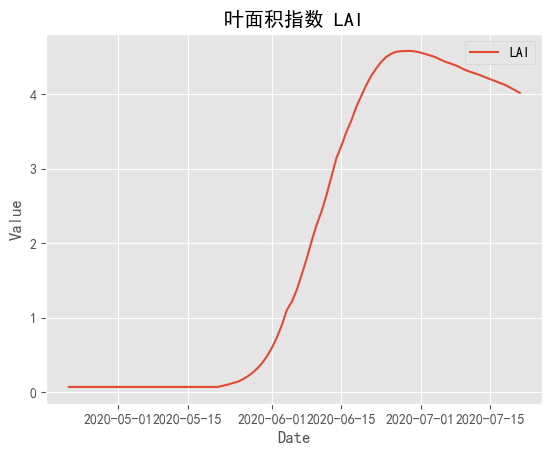

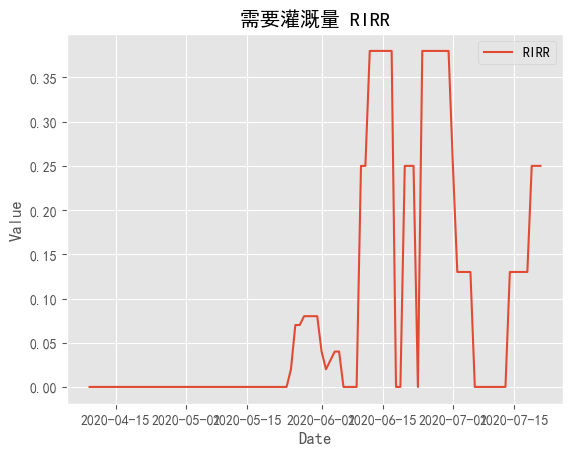

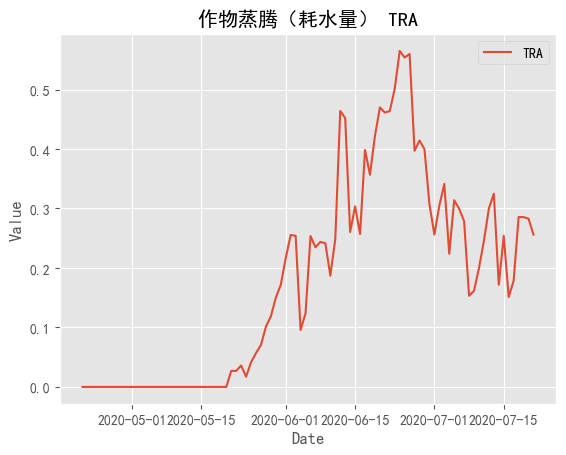

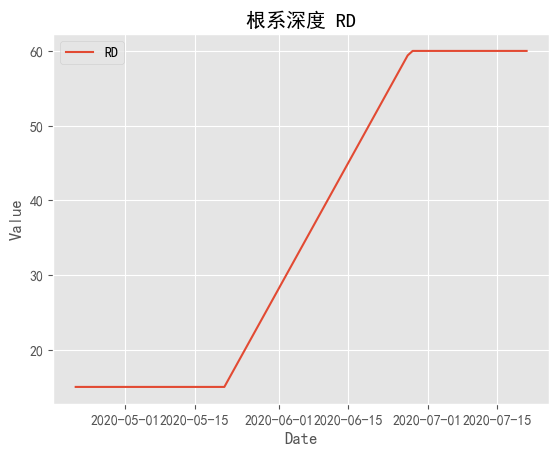

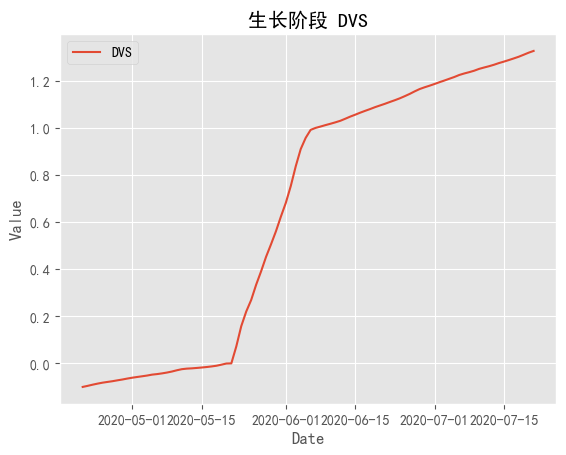

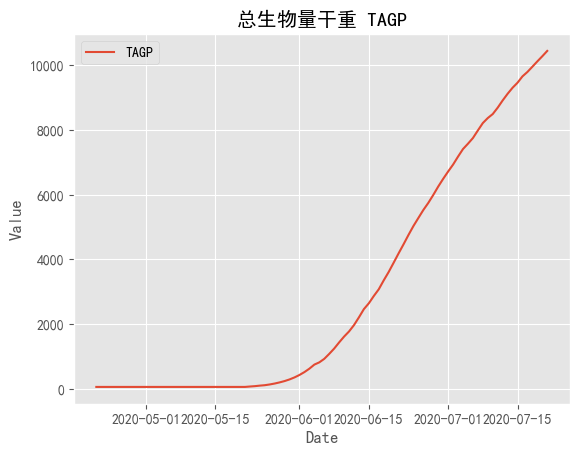

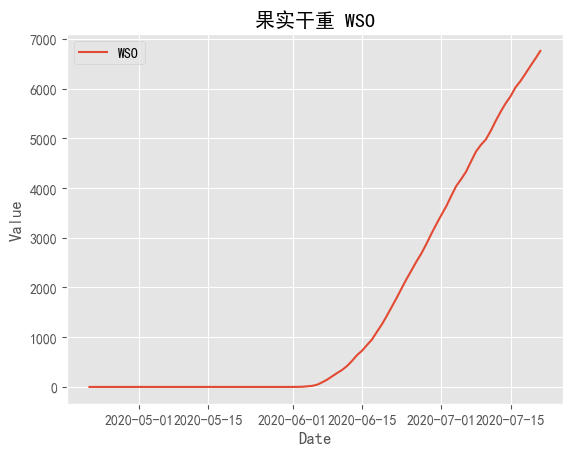

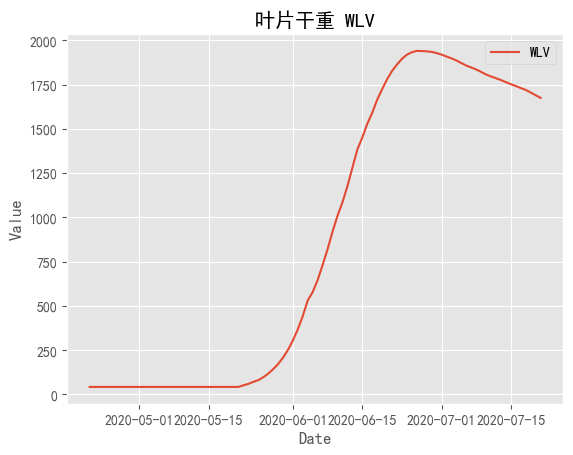

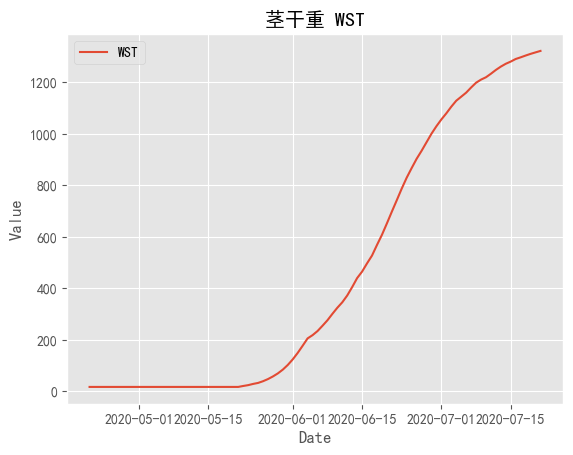

In [61]:
#  这里通过多次对ax赋值的方式依次绘制多个不同变量的图形，每个图形都会在同一个绘图区域（如果没有额外设置图形布局的话）进行展示。
ax = df_output.plot(x='day', y='LAI', title="叶面积指数 LAI", ylabel="Value", xlabel="Date")  

# 此时无法绘制土壤含水量（SM_1代表第一层土壤的含水量，推测后续SM_2、SM_3、SM_4同理代表不同土层的含水量）随时间变化的折线图，
# 设置图形标题、纵坐标标签和横坐标标签，同样将返回的Axes对象赋值给ax变量，方便后续继续调整图形样式等操作。

# ax = df_output.plot(x='day', y='SM_1', title="土壤含水量 SM_1", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='SM_2', title="土壤含水量 SM_2", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='SM_3', title="土壤含水量 SM_3", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='SM_4', title="土壤含水量 SM_4", ylabel="Value", xlabel="Date")  
# 以及
# ax = df_output.plot(x='day', y='SM', title="土壤含水量 SM", ylabel="Value", xlabel="Date")  

# 绘制需要灌溉量（RIRR）随时间变化的折线图，设置相应的图形标题、坐标轴标签，并将Axes对象赋值给ax变量。 rirr rate of irrigation cm/day
ax = df_output.plot(x='day', y='RIRR', title="需要灌溉量 RIRR", ylabel="Value", xlabel="Date")  

# 以下几行代码被注释掉了，说明暂时不执行这部分绘图操作，可能是出于当前不需要展示这些变量图形或者后续会根据情况再决定是否绘制等原因，
# 如果取消注释，就会分别绘制总灌溉量（TOTIRR）、灌溉量（IRRIG）、渗漏量（WBOT，注释中说明了其代表的含义是超出最大可扎根深度且植物无法利用的水量）随时间变化的折线图。
# ax = df_output.plot(x='day', y='TOTIRR', title="总灌溉量 TOTIRR", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='IRRIG', title="灌溉量 IRRIG", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='WBOT', title="渗漏量 WBOT", ylabel="Value", xlabel="Date")  
# WBOT, Water below maximum rootable depth and unavailable for plant growth.  

# 绘制作物蒸腾（耗水量，TRA表示）随时间变化的折线图，设置图形标题、坐标轴标签，并将Axes对象赋值给ax变量，
# 通过绘制这个图形可以直观了解作物在不同时间的蒸腾耗水情况，对于分析作物的水分利用效率等方面有帮助。
ax = df_output.plot(x='day', y='TRA', ylabel="Value", xlabel="Date", title="作物蒸腾（耗水量） TRA")  

# 绘制根系深度（RD）随时间变化的折线图，设置相应的图形属性，便于查看作物根系在整个生长周期内深度的变化趋势，
# 根系深度对于了解作物对土壤不同深度水分和养分的获取能力等方面有着重要意义。
ax = df_output.plot(x='day', y='RD', title="根系深度 RD", ylabel="Value", xlabel="Date")  

# 绘制生长阶段（DVS，可能代表作物发育阶段的某个指标，比如从播种到成熟不同阶段的量化表示）随时间变化的折线图，
# 设置图形的相关标签，通过该图可以清晰看到作物在整个生长周期内所处的发育阶段变化情况，有助于分析作物生长规律。
ax = df_output.plot(x='day', y='DVS', title="生长阶段 DVS", ylabel="Value", xlabel="Date")  

# 绘制总生物量干重（TAGP）随时间变化的折线图，设置图形的标题、坐标轴标签等，
# 总生物量干重是衡量作物生长状况和生产力的一个重要指标，通过这个图形可以直观观察其在整个生长周期内的积累变化过程。
ax = df_output.plot(x='day', y='TAGP', title="总生物量干重 TAGP", ylabel="Value", xlabel="Date")  

# 以下几行代码被注释掉了，和前面类似，暂时不执行绘制果实干重（TWSO、WSO，可能是不同表示方式或不同阶段的果实干重相关变量）、
# 叶片干重（TWLV、WLV）、茎干重（TWST、WST）随时间变化的折线图的操作，可能根据后续实际需求决定是否绘制展示这些作物不同器官干重变化情况的图形。

# WOFOST 7.2 版本的输出变量：
# ax = df_output.plot(x='day', y='TWSO', title="果实干重 TWSO", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='TWLV', title="叶片干重 TWLV", ylabel="Value", xlabel="Date")  
# ax = df_output.plot(x='day', y='TWST', title="茎干重 TWST", ylabel="Value", xlabel="Date")  

# WOFOST 8.1 版本的输出变量：
# wlv
# dry weight of living leaves
# wofost_leaf_dynamics
# kg ha-1

# wso
# dry weight of living storage organs
# wofost_storage_organ_dynamics
# kg ha-1

# wrt
# dry weight of living roots
# wofost_root_dynamics
# kg ha-1

# wst
# dry weight of living stems
# wofost_stem_dynamics
# kg ha-1

ax = df_output.plot(x='day', y='WSO', title="果实干重 WSO", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='WLV', title="叶片干重 WLV", ylabel="Value", xlabel="Date")  
ax = df_output.plot(x='day', y='WST', title="茎干重 WST", ylabel="Value", xlabel="Date")